In [1]:
%pip install -q "pymoo>=0.6.1"


Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Config ---
from pathlib import Path
import numpy as np

# (Your existing locations)
ML_FRONT_PATH = '/Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/front_ml.csv'
NSGA_OUTPUTS_DIR = '/Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/exp'

# Convert to Path objects
ML_FRONT_PATH    = Path(ML_FRONT_PATH)
NSGA_OUTPUTS_DIR = Path(NSGA_OUTPUTS_DIR)

# Global simulator params (keep consistent with generation)
BED_SIZE_X = 70
BED_SIZE_Z = 20
RECLAIM_X_PER_S = 8

# Repro
np.random.seed(42)

print("[cfg] NSGA_OUTPUTS_DIR =", NSGA_OUTPUTS_DIR)

[cfg] NSGA_OUTPUTS_DIR = /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/exp


In [3]:
# === Output routing: send ALL outputs of THIS notebook into "sim re-eval" ===
from pathlib import Path

BASE_RESULTS = Path("/Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results")

SIM_EVAL_DIR    = BASE_RESULTS / "sim re-eval"
SIM_FRONTS_DIR  = SIM_EVAL_DIR / "fronts"   # re-evaluated copies live here
FIG_DIR         = SIM_EVAL_DIR / "figs"     # figures here
RESULTS_DIR     = SIM_EVAL_DIR              # tables here

for p in (SIM_EVAL_DIR, SIM_FRONTS_DIR, FIG_DIR):
    p.mkdir(parents=True, exist_ok=True)

print("[out] RESULTS_DIR      →", RESULTS_DIR)
print("[out] FIG_DIR          →", FIG_DIR)
print("[out] SIM_FRONTS_DIR   →", SIM_FRONTS_DIR)

[out] RESULTS_DIR      → /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval
[out] FIG_DIR          → /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/figs
[out] SIM_FRONTS_DIR   → /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/fronts


In [4]:
# --- Core imports (project & libs) ---
import pandas as pd
import matplotlib.pyplot as plt

# Project-specific (must be importable in your env)
from bmh.benchmark.material_deposition import MaterialDeposition, Material, Deposition
from bmh.simulation.bsl_blending_simulator import BslBlendingSimulator
from bmh.helpers.math import stdev
from bmh.helpers.stockpile_math import get_stockpile_height, get_stockpile_slice_volume

print("[ok] BMH modules imported")

[ok] BMH modules imported


## Simulator wrapper (ground truth)

In [5]:
# Define ReclaimedMaterialEvaluator 
from bmh.helpers.math import stdev
from bmh.helpers.stockpile_math import get_stockpile_height, get_stockpile_slice_volume

class ReclaimedMaterialEvaluator:
    """
    Computes the volume/height variability metric by comparing the reclaimed
    volume series to an 'ideal' stockpile slice profile (same total volume).
    """
    def __init__(self, reclaimed, x_min: float, x_max: float):
        self.reclaimed = reclaimed
        self.x_min = float(x_min)
        self.x_max = float(x_max)
        self._volume_stdev = None

    def get_volume_stdev(self) -> float:
        if self._volume_stdev is None:
            ideal_df = self.reclaimed.data.copy()
            core_len = self.x_max - self.x_min

            # Ideal height for same total volume and core length
            ideal_height = get_stockpile_height(
                volume=float(ideal_df["volume"].sum()),
                core_length=core_len
            )

            # Compute ideal slice volumes along x
            ideal_df["x_diff"] = (ideal_df["x"] - ideal_df["x"].shift(1)).fillna(0.0)
            ideal_df["volume"] = ideal_df.apply(
                lambda row: get_stockpile_slice_volume(
                    x=row["x"],
                    core_length=core_len,
                    height=ideal_height,
                    x_min=self.x_min,
                    x_diff=row["x_diff"]
                ),
                axis=1
            )

            # Std dev of deviation from ideal volume profile
            self._volume_stdev = stdev(
                (ideal_df["volume"] - self.reclaimed.data["volume"]).values
            )

        return float(self._volume_stdev)


In [ ]:
# === Ground-truth simulator wrapper ===
import numpy as np
import pandas as pd

def row_to_qx(row, expect_q: int = 50, expect_x: int = 20):
    """
    Extracts the quality curve q (x1..x50) and deposition positions x (x51..x70)
    from a row with columns x1..x70. Raises with a clear message if columns are missing.
    """
    # Gather and order x-columns
    xcols = [c for c in row.index if str(c).startswith("x")]
    if not xcols:
        raise KeyError("No x# columns found (expected x1..x70).")
    xcols = sorted(xcols, key=lambda s: int(str(s)[1:]))

    vals = np.array([row[c] for c in xcols], dtype=float)
    need = expect_q + expect_x
    if vals.size < need:
        raise ValueError(
            f"Expected at least {need} x-columns (first {expect_q} for q, next {expect_x} for deposition), "
            f"but found {vals.size}. Missing some x# columns."
        )

    q = vals[:expect_q]
    x = vals[expect_q:expect_q + expect_x]

    if not np.all(np.isfinite(q)) or not np.all(np.isfinite(x)):
        raise ValueError("NaN/inf detected in extracted q/x vectors.")
    return q, x


def resimulate_solution(q_vec,
                        x_vec,
                        bed_size_x: float = None,
                        bed_size_z: float = None,
                        reclaim_x_per_s: float = None,
                        inflow_volume: float = None):
    """
    Compute ground-truth objectives for a candidate solution using the BMH simulator.

    Returns
    -------
    (y1, y2) : tuple of floats
        y1 = volume-weighted standard deviation of reclaimed quality (minimise)
        y2 = volume/height variability from ReclaimedMaterialEvaluator (minimise)
    """
    # Resolve defaults from globals or fallbacks
    BX  = float(bed_size_x      if bed_size_x      is not None else globals().get("BED_SIZE_X", 70.0))
    BZ  = float(bed_size_z      if bed_size_z      is not None else globals().get("BED_SIZE_Z", 20.0))
    RX  = float(reclaim_x_per_s if reclaim_x_per_s is not None else globals().get("RECLAIM_X_PER_S", 8.0))
    VOL = float(inflow_volume   if inflow_volume   is not None else globals().get("DEFAULT_INFLOW_VOLUME", 50.0))

    # Basic validation & shaping
    q = np.asarray(q_vec, dtype=float).reshape(-1)
    x = np.asarray(x_vec, dtype=float).reshape(-1)
    if q.size == 0 or x.size == 0:
        raise ValueError(f"Empty q ({q.size}) or x ({x.size}) vector.")
    if not np.all(np.isfinite(q)) or not np.all(np.isfinite(x)):
        raise ValueError("q_vec/x_vec contain NaN/inf.")

    # --- Build material time series ---
    t_material = np.linspace(0.0, 100.0, q.size)
    mat_df = pd.DataFrame({
        "timestamp": t_material,
        "volume":    np.full(q.size, VOL, dtype=float),
        "quality":   q
    })
    material = Material.from_data(mat_df)

    # --- Build deposition sequence ---
    t_deposition = np.linspace(0.0, 100.0, x.size)
    dep_df = pd.DataFrame({
        "timestamp": t_deposition,
        "x": x.astype(float),
        "z": np.full(x.size, 0.5 * BZ, dtype=float)  # mid-height
    })
    deposition = Deposition.from_data(
        data=dep_df,
        bed_size_x=BX,
        bed_size_z=BZ,
        reclaim_x_per_s=RX
    )

    # --- Stack & reclaim ---
    sim = BslBlendingSimulator(bed_size_x=BX, bed_size_z=BZ)
    reclaimed = sim.stack_reclaim(MaterialDeposition(material=material, deposition=deposition))

    # --- Objective 1: quality variability (volume-weighted std) ---
    qual = np.asarray(reclaimed.data["quality"], dtype=float)
    vol  = np.asarray(reclaimed.data["volume"],  dtype=float)
    mu = np.average(qual, weights=vol)
    y1 = float(np.sqrt(np.average((qual - mu) ** 2, weights=vol)))

    # --- Objective 2: volume/height variability via evaluator ---
    evaluator = ReclaimedMaterialEvaluator(
        reclaimed=reclaimed,
        x_min=float(np.min(x)),
        x_max=float(np.max(x))
    )
    y2 = float(evaluator.get_volume_stdev())

    return y1, y2


 ## Utilities (Pareto/HV/IGD, filename parser, hashing)

In [ ]:
import re, gc, warnings, math
from pathlib import Path
from typing import Dict, Any, Tuple, Optional, Iterable

import numpy as np
import pandas as pd
from tqdm import tqdm

# Metrics & ND front utilities (pymoo)
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD

# Stats
from scipy import stats as st

# Paths
SRC = Path("Results/exp")                     # predicted fronts from the model notebook
DST = Path("Results/sim_reeval/fronts")       # re-evaluated fronts go here
ANL = Path("Results/analysis")                # tables
FIG = Path("Results/figs")                    # figures
for p in (DST, ANL, FIG): p.mkdir(parents=True, exist_ok=True)

DTYPE = np.float32

# Parse filename tags: supports both with and without _nvars{K}
_TAG_RE = re.compile(
    r"^front_model(?P<model>[^_]+)_pop(?P<pop>\d+)_evals(?P<evals>\d+)"
    r"(?:_nvars(?P<nvars>\d+))?_curve(?P<curve>\d+)_run(?P<seed>\d+)\.csv$"
)

def parse_tags(p) -> Optional[Dict[str, Any]]:
    """Accepts a filename as str or Path; returns parsed tags dict or None."""
    name = Path(p).name
    m = _TAG_RE.match(name)
    if not m:
        return None
    d = m.groupdict()
    for k in ("pop","evals","nvars","curve","seed"):
        if d.get(k) is not None:
            d[k] = int(d[k])
    return d

def list_source_fronts() -> list[Path]:
    return [p for p in SRC.glob("front_*.csv") if not p.name.startswith("front_sim_")]

def nd_filter(F: np.ndarray) -> np.ndarray:
    """Return indices of the non-dominated front (minimization)."""
    if len(F) == 0:
        return np.array([], dtype=int)
    I = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return np.asarray(I, dtype=int)

def ref_point_for_hv(*arrays: Iterable[np.ndarray], pad: float = 1.10) -> np.ndarray:
    """Reference point = pad * max over all provided arrays (minimization HV)."""
    allF = np.vstack([a for a in arrays if a is not None and len(a) > 0])
    mx = np.max(allF, axis=0)
    return (mx * pad).astype(np.float64)

def knee_point(F: np.ndarray) -> Optional[np.ndarray]:
    """Simple knee detector: max distance to the line between extremes on ND-sorted, min-normalized front."""
    if len(F) < 3:
        return None
    # Keep ND front & sort by first objective
    I = nd_filter(F)
    P = F[I] if len(I) else F
    P = P[np.argsort(P[:,0])]
    # Normalize
    mn, mx = P.min(axis=0), P.max(axis=0)
    rng = np.where(mx - mn == 0, 1.0, mx - mn)
    Q = (P - mn) / rng
    # Line from first to last
    a, b = Q[0], Q[-1]
    v = b - a
    v /= (np.linalg.norm(v) + 1e-12)
    # Distances to the line
    w = Q - a
    proj = (w @ v)[:,None] * v
    perp = w - proj
    d = np.linalg.norm(perp, axis=1)
    j = int(np.argmax(d))
    return P[j]  # return in original (non-normalized) scale


 ## Re-evaluate fronts → copies in `sim re-eval/fronts`

In [ ]:
# CELL B — Re-evaluate predicted fronts (write copies as "front_sim_*.csv")

from pathlib import Path

try:
    SIM_FRONTS_DIR
except NameError:
    SIM_FRONTS_DIR = DST  # Results/sim_reeval/fronts

if "resimulate_solution" not in globals():
    raise RuntimeError("Define resimulate_solution(...) first (see your simulator cell).")

try:
    src_files = files_scan
except NameError:
    src_files = [str(p) for p in SRC.glob("front_*.csv") if not p.name.startswith("front_sim_")]

files_all, updated, skipped = [], 0, 0

for f in src_files:
    src = Path(f)
    out = SIM_FRONTS_DIR / ("front_sim_" + src.name)  # idempotent target name
    if out.exists():
        skipped += 1
        files_all.append(str(out))
        continue

    df = pd.read_csv(src)

    # Compute simulated objectives for each row
    y1s, y2s = [], []
    for _, row in df.iterrows():
        q, x = row_to_qx(row)                
        y1, y2 = resimulate_solution(q, x)   
        y1s.append(float(y1)); y2s.append(float(y2))
    df["y1_sim"], df["y2_sim"] = y1s, y2s
    updated += 1

    df.to_csv(out, index=False)
    files_all.append(str(out))

print(f"[done] wrote {len(files_all)} files to {SIM_FRONTS_DIR} (updated {updated}, skipped {skipped})")


[done] wrote 235 files to /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/fronts (updated 0, skipped 235)


# Affine calibration

In [ ]:
# CELL — Affine calibration (per model & objective) + quick HV check

import numpy as np, pandas as pd
from pathlib import Path

# Collect per-model calibration: y_sim ≈ a + b * y_pred
cal_rows = []
for fp in files_all:
    df = pd.read_csv(fp)
    req = {'model','y1_pred','y2_pred','y1_sim','y2_sim'}
    if not req.issubset(df.columns):
        continue
    m = df[list(req)].dropna()

    for model in sorted(m['model'].unique()):
        mm = m[m['model'] == model]

        # y1 calibration
        if len(mm) >= 20 and mm['y1_pred'].nunique() >= 2:
            slope, intercept = np.polyfit(mm['y1_pred'].to_numpy(float),
                                          mm['y1_sim'].to_numpy(float), 1)
            cal_rows.append({'model': model, 'obj': 'y1',
                             'a': float(intercept), 'b': float(slope), 'N': int(len(mm))})

        # y2 calibration
        if len(mm) >= 20 and mm['y2_pred'].nunique() >= 2:
            slope, intercept = np.polyfit(mm['y2_pred'].to_numpy(float),
                                          mm['y2_sim'].to_numpy(float), 1)
            cal_rows.append({'model': model, 'obj': 'y2',
                             'a': float(intercept), 'b': float(slope), 'N': int(len(mm))})

calib = (pd.DataFrame(cal_rows)
         .sort_values(['model','obj','N'], ascending=[True, True, False])
         .drop_duplicates(subset=['model','obj'], keep='first')
         .reset_index(drop=True))

# Save to the analysis folder defined in Cell A
calib_path = ANL / "calibration_affine.csv"
calib.to_csv(calib_path, index=False)
try:
    from IPython.display import display
    display(calib)
except Exception:
    print(calib.head())
print("Saved:", calib_path)

# --- Helper to apply calibration back onto a DataFrame ---
def apply_calibration(df: pd.DataFrame, calib_table: pd.DataFrame, model_col: str = 'model') -> pd.DataFrame:
    out = df.copy()
    for obj in ['y1','y2']:
        pred_col = f"{obj}_pred"
        cal_col  = f"{obj}_pred_cal"
        if pred_col not in out.columns:
            continue
        out[cal_col] = out[pred_col]  # default: identity (in case model not in table)
        sub = calib_table[calib_table['obj'] == obj]
        for _, r in sub.iterrows():
            mask = (out[model_col] == r['model'])
            out.loc[mask, cal_col] = r['a'] + r['b'] * out.loc[mask, pred_col]
    return out

# ---  HV(pred_cal) vs HV(sim) using pymoo HV ---
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV

def _nd(X):
    if len(X) == 0: return X
    I = NonDominatedSorting().do(X, only_non_dominated_front=True)
    return X[np.asarray(I, dtype=int)]

if len(files_all):
    fp = files_all[0]
    df0 = pd.read_csv(fp)
    if {'y1_pred','y2_pred','y1_sim','y2_sim'}.issubset(df0.columns):
        d2 = apply_calibration(df0, calib)
        P_cal = d2[['y1_pred_cal','y2_pred_cal']].dropna().to_numpy(float)
        P_sim = d2[['y1_sim','y2_sim']].dropna().to_numpy(float)

        P_cal_nd = _nd(P_cal) if len(P_cal) else P_cal
        P_sim_nd = _nd(P_sim) if len(P_sim) else P_sim

        ref = ref_point_for_hv(P_cal_nd, P_sim_nd, pad=1.05)  
        hv = HV(ref_point=ref)
        hv_cal = float(hv(P_cal_nd)) if len(P_cal_nd) else np.nan
        hv_sim = float(hv(P_sim_nd)) if len(P_sim_nd) else np.nan

        print(Path(fp).name, "HV(pred_cal)=", hv_cal, "HV(sim)=", hv_sim)


,model,obj,a,b,N
0,lstm,y1,15.133830,-33.071109,200
1,lstm,y2,636.919380,-47.570655,200
2,mlp,y1,-0.034147,1.298637,200
3,mlp,y2,33.936083,-1.935109,200
4,xgb,y1,-1.115077,2.810458,200
5,xgb,y2,15.797537,-1.784923,200


Saved: Results/analysis/calibration_affine.csv
front_sim_front_modellstm_pop100_evals20000_curve1_run4.csv HV(pred_cal)= 2.017630678658436 HV(sim)= 10.978812869994108


# Simulator Refinement

In [ ]:
# CELL — Simulator-side local polishing of deposition x (keeps q fixed)
import numpy as np
import pandas as pd
from pathlib import Path

def polish_x_with_sim(q, x0, iters=60, sigma0=2.0, bounds=(10.0,49.0), w=(0.5,0.5), seed=0):
    """
    Simple random-restart hill-climb on the simulator objective.
    Minimises w1*y1 + w2*y2 with Gaussian perturbations and accept-if-better.
    """
    rng = np.random.default_rng(int(seed))
    lb, ub = float(bounds[0]), float(bounds[1])

    best_x = np.clip(np.array(x0, float), lb, ub)
    y1, y2 = resimulate_solution(q, best_x)
    best_y = (float(y1), float(y2))
    best_s = w[0]*best_y[0] + w[1]*best_y[1]

    sigma = float(sigma0)
    for t in range(int(iters)):
        noise = rng.normal(0.0, sigma, size=best_x.size)
        noise = np.convolve(noise, np.ones(3)/3, mode='same')  # smooth step
        cand_x = np.clip(best_x + noise, lb, ub)
        y1c, y2c = resimulate_solution(q, cand_x)
        sc = w[0]*y1c + w[1]*y2c
        if sc < best_s:
            best_x, best_y, best_s = cand_x, (float(y1c), float(y2c)), float(sc)
        sigma = max(0.2, sigma*0.95)  # cool down
    return best_x, best_y


try:
    files_list = files_all
except NameError:
    files_list = [str(p) for p in DST.glob("front_sim_*.csv")]

improved = []
count = 0
MAX_EVALS = 50  

for f_idx, fp in enumerate(files_list):
    df = pd.read_csv(fp)

    use_n = min(50, len(df))  
    for i in range(use_n):
        q, x = row_to_qx(df.iloc[i])
        x_new, (y1_new, y2_new) = polish_x_with_sim(
            q, x, iters=60, sigma0=2.0, bounds=(10.0,49.0), w=(0.5,0.5), seed=1000*f_idx + i
        )

        # parse tags: strip "front_sim_" to reuse the Cell A parser
        tags = parse_tags(Path(fp).name.replace("front_sim_", "")) or {}

        improved.append({
            **tags,
            "row": i,
            "y1_before": float(df.iloc[i].get("y1_sim", np.nan)),
            "y2_before": float(df.iloc[i].get("y2_sim", np.nan)),
            "y1_after":  float(y1_new),
            "y2_after":  float(y2_new)
        })

        count += 1
        if count >= MAX_EVALS:
            break
    if count >= MAX_EVALS:
        break

imp = pd.DataFrame(improved)
try:
    from IPython.display import display
    display(imp.head())
except Exception:
    print(imp.head())

print("Median Δy1:", float(np.nanmedian(imp["y1_after"] - imp["y1_before"])) if len(imp) else np.nan)
print("Median Δy2:", float(np.nanmedian(imp["y2_after"] - imp["y2_before"])) if len(imp) else np.nan)

out_path = ANL / "sim_polish_sample.csv"  
imp.to_csv(out_path, index=False)
print("Saved:", out_path)


,model,pop,evals,nvars,curve,seed,row,y1_before,y2_before,y1_after,y2_after
0,lstm,100,20000,None,1,4,0,0.400878,22.578051,0.423339,3.194467
1,lstm,100,20000,None,1,4,1,0.690649,36.737441,0.656011,24.392628
2,lstm,100,20000,None,1,4,2,0.726106,32.286282,0.723443,20.562092
3,lstm,100,20000,None,1,4,3,0.520926,39.666686,0.540558,24.481501
4,lstm,100,20000,None,1,4,4,0.741296,33.922592,0.747571,21.720026


Median Δy1: 0.0033260134914160355
Median Δy2: -11.366802080348354
Saved: Results/analysis/sim_polish_sample.csv


 ## Sensitivity scenarios (quality curve transforms)

In [11]:
# CELL — Quality-curve sensitivity scenarios (smooth/baseline/choppy/noisy)

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.ndimage import gaussian_filter1d

# Deterministic noise for reproducibility
_rng = np.random.default_rng(42)

scenarios = {
    "smooth":   lambda q: gaussian_filter1d(q, sigma=2.0),
    "baseline": lambda q: gaussian_filter1d(q, sigma=1.0),
    "choppy":   lambda q: gaussian_filter1d(q, sigma=0.3),
    "noisy":    lambda q: q + _rng.normal(0, 0.15*np.std(q), size=len(q)),
}

def scenario_resim(row: pd.Series) -> pd.Series:
    q0, x = row_to_qx(row)
    out = {}
    for name, transform in scenarios.items():
        q = transform(q0.copy())
        y1, y2 = resimulate_solution(q, x)
        out[f"y1_{name}"] = float(y1)
        out[f"y2_{name}"] = float(y2)
    return pd.Series(out)

# Source list: use files_all if available; otherwise scan the re-eval folder (DST)
try:
    files_list = files_all
except NameError:
    files_list = [str(p) for p in DST.glob("front_sim_*.csv")]

# Build a pool with only x1..x70 (keeps memory small)
xcols = [f"x{i}" for i in range(1, 71)]
frames = []
for f in files_list:
    try:
        frames.append(pd.read_csv(f, usecols=xcols))
    except Exception:
        # If a file is missing columns, skip it
        continue

if not frames:
    raise RuntimeError("No re-evaluated fronts found to run sensitivity analysis on.")

df_all_for_sens = pd.concat(frames, ignore_index=True)

# Sample up to 200 rows for quick turnaround (tweak as needed)
subset_n = min(200, len(df_all_for_sens))
subset = df_all_for_sens.sample(subset_n, random_state=42)

sens = subset.apply(scenario_resim, axis=1)
sens_stats = sens.describe().T

# Save + preview
out_path = ANL / "sensitivity_scenarios_summary.csv"
sens_stats.to_csv(out_path, index=False)

try:
    from IPython.display import display
    display(sens_stats.head())
except Exception:
    print(sens_stats.head())

print(f"[ok] Sensitivity scenarios evaluated on {subset_n} rows. Saved summary to {out_path}")


,count,mean,std,min,25%,50%,75%,max
y1_smooth,200.0,0.544519,0.183565,0.221814,0.390644,0.547242,0.663294,1.218527
y2_smooth,200.0,25.530743,12.315049,6.880399,14.928696,22.463371,35.582750,52.199862
y1_baseline,200.0,0.565362,0.186553,0.215179,0.413673,0.563326,0.681589,1.274161
y2_baseline,200.0,25.496104,12.293871,6.945624,14.984354,22.553435,35.694597,51.846149
y1_choppy,200.0,0.585466,0.187398,0.223821,0.444495,0.570102,0.701216,1.320479


[ok] Sensitivity scenarios evaluated on 200 rows. Saved summary to Results/analysis/sensitivity_scenarios_summary.csv


## Run-level metrics (HV, IGD, Pred→Sim shift) + summaries

In [ ]:
# CELL C — Metrics by run (HV/IGD/shift) and by setting (aggregates)

import numpy as np, pandas as pd
from pathlib import Path

# Source list: prefer files_all from Cell B; else scan re-eval dir
try:
    files_list = files_all
except NameError:
    files_list = [str(p) for p in DST.glob("front_sim_*.csv")]

def _safe_nd(F):
    if F is None or len(F) == 0:
        return np.empty((0,2), dtype=float)
    I = nd_filter(F)
    return F[I] if len(I) else F

rows = []
for f in files_list:
    name = Path(f).name
    # strip "front_sim_" to reuse the standard parser
    tags = parse_tags(Path(name.replace("front_sim_", "")))
    if not tags:
        continue

    df = pd.read_csv(f)

    # Predicted & simulated objectives
    has_pred = {'y1_pred','y2_pred'}.issubset(df.columns)
    Fp = df[['y1_pred','y2_pred']].to_numpy(dtype=float) if has_pred else np.empty((0,2))
    Fs = df[['y1_sim','y2_sim']].to_numpy(dtype=float)

    # Non-dominated fronts
    Fp_nd = _safe_nd(Fp)
    Fs_nd = _safe_nd(Fs)

    # Hypervolume (minimization) with adaptive or fixed ref (from Cell A)
    ref = ref_point_for_hv(Fp_nd if len(Fp_nd) else None, Fs_nd if len(Fs_nd) else None, pad=1.10)
    hv = HV(ref_point=ref)
    hv_pred = float(hv(Fp_nd)) if len(Fp_nd) else np.nan
    hv_sim  = float(hv(Fs_nd)) if len(Fs_nd) else np.nan
    hv_drop = (hv_pred - hv_sim) if (not np.isnan(hv_pred) and not np.isnan(hv_sim)) else np.nan

    # IGD (predicted → simulated) on ND fronts
    igd_ps = IGD(Fs_nd)(Fp_nd) if (len(Fs_nd) and len(Fp_nd)) else np.nan

    # Mean per-point shift (1–1 rows)
    shift_mean = np.nan
    if len(Fp) == len(Fs) and len(Fp) > 0:
        shift_mean = float(np.linalg.norm(Fs - Fp, axis=1).mean())

    rows.append({
        **tags,
        "n_points": int(len(df)),
        "hv_pred": hv_pred,
        "hv_sim": hv_sim,
        "hv_drop": hv_drop,
        "igd_pred_to_sim": float(igd_ps) if not np.isnan(igd_ps) else np.nan,
        "shift_mean": shift_mean,
        "ref1": float(ref[0]), "ref2": float(ref[1]),
    })

runs = pd.DataFrame(rows)

# Sort with columns that exist (seed vs run, nvars )
sort_cols = [c for c in ["model","evals","pop","nvars","curve","seed"] if c in runs.columns]
if sort_cols:
    runs = runs.sort_values(sort_cols).reset_index(drop=True)

# Save (standard location)
runs_path = ANL / "results_metrics_by_run.csv"
runs.to_csv(runs_path, index=False)
print("[ok] wrote", runs_path)

# also write legacy filenames if you were using them before:
if "RESULTS_DIR" in globals():
    legacy_runs = Path(RESULTS_DIR) / "results_runs_metrics.csv"
    runs.to_csv(legacy_runs, index=False)
    print("[ok] (compat) wrote", legacy_runs)

# ----- By setting aggregates -----
group_cols = [c for c in ["model","pop","evals","nvars"] if c in runs.columns]
by_setting = (runs
    .groupby(group_cols, dropna=False)
    .agg(
        runs=("hv_sim","size"),
        hv_sim_mean=("hv_sim","mean"),
        hv_sim_sd=("hv_sim","std"),
        hv_drop_mean=("hv_drop","mean"),
        igd_mean=("igd_pred_to_sim","mean"),
        shift_mean=("shift_mean","mean")
    )
    .reset_index()
    .sort_values(group_cols))

by_path = ANL / "results_metrics_by_setting.csv"
by_setting.to_csv(by_path, index=False)
print("[ok] wrote", by_path)

# (Optional) legacy filename
if "RESULTS_DIR" in globals():
    legacy_by = Path(RESULTS_DIR) / "results_metrics_by_setting.csv"
    by_setting.to_csv(legacy_by, index=False)
    print("[ok] (compat) wrote", legacy_by)

try:
    from IPython.display import display
    display(by_setting.head())
except Exception:
    print(by_setting.head())


[ok] wrote Results/analysis/results_metrics_by_run.csv
[ok] (compat) wrote /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/results_runs_metrics.csv
[ok] wrote Results/analysis/results_metrics_by_setting.csv
[ok] (compat) wrote /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/results_metrics_by_setting.csv


,model,pop,evals,nvars,runs,hv_sim_mean,hv_sim_sd,hv_drop_mean,igd_mean,shift_mean
0,lstm,50,10000,10.0,2,1.106046,0.032636,-0.762171,2.785898,5.462279
1,lstm,50,15000,15.0,1,0.779284,NaN,3.662119,7.642126,15.433371
2,lstm,50,20000,20.0,1,0.304264,NaN,-0.226786,0.207146,25.278235
3,lstm,50,20000,NaN,9,0.297520,0.041958,-0.103028,1.697476,25.401272
4,lstm,50,40000,NaN,9,1.510666,0.525964,-0.842500,6.045992,26.579207


### Surrogate calibration & bias (y1/y2): scatter, MAE/RMSE/R², Bland–Altman

[calib] paired rows: 23638


,y1_pred,y2_pred,y1_sim,y2_sim
0,0.443899,12.47107,0.400878,22.578051
1,0.435116,12.65389,0.690649,36.737441
2,0.435492,12.63804,0.726106,32.286282
3,0.443007,12.48167,0.520926,39.666686
4,0.436184,12.60932,0.741296,33.922592
5,0.440474,12.51958,0.561762,43.946179
6,0.438146,12.56328,0.656132,40.423530
7,0.436308,12.60506,0.727830,35.390033
8,0.440283,12.52324,0.595524,46.116055
9,0.436427,12.60050,0.721632,35.212279


[calib] y1: MAE=0.1382 RMSE=0.1754 R²=0.0720


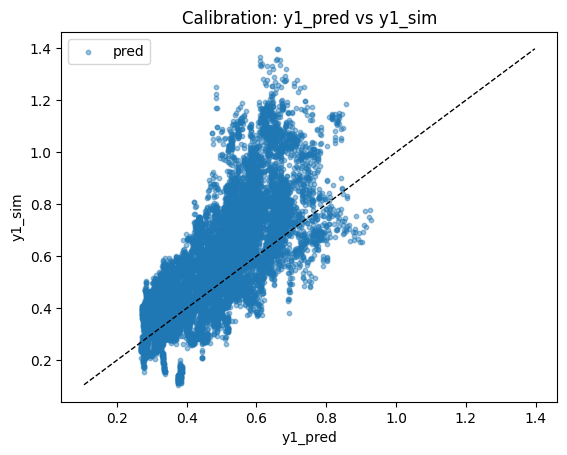

Saved: Results/figs/calibration_scatter_y1.png


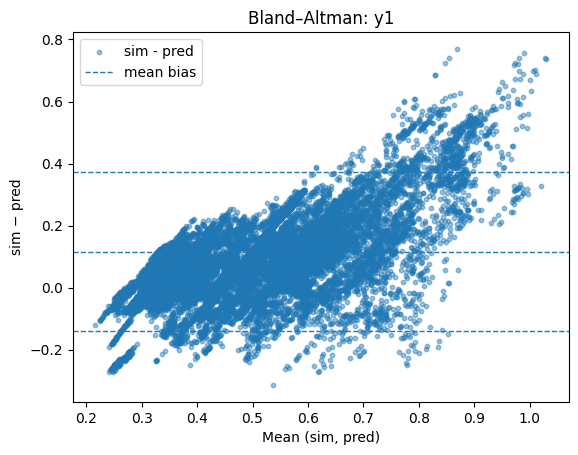

Saved: Results/figs/bland_altman_y1.png
[calib] y2: MAE=16.74 RMSE=19.79 R²=-1.6272


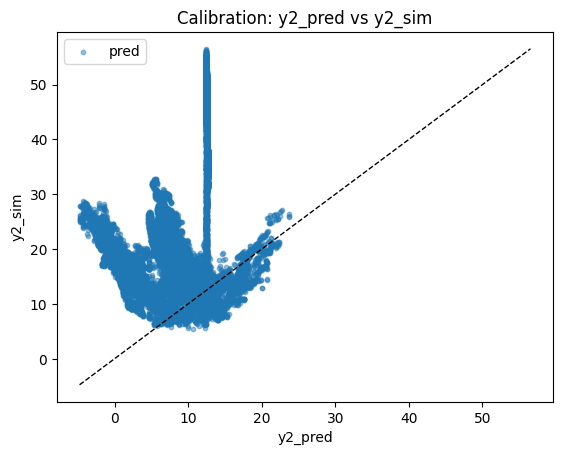

Saved: Results/figs/calibration_scatter_y2.png


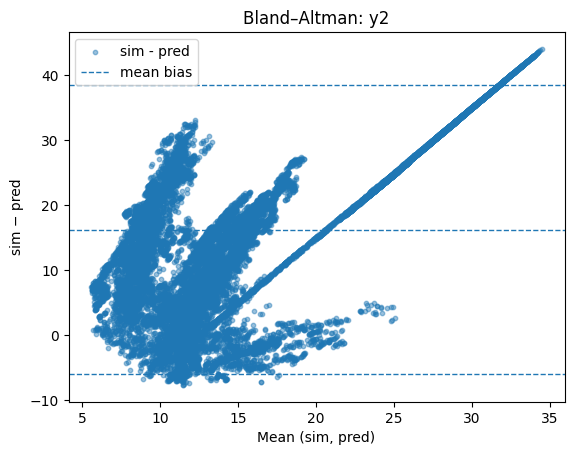

Saved: Results/figs/bland_altman_y2.png


In [ ]:
# CELL — Paired pred vs sim diagnostics (scatter + Bland–Altman), with optional calibrated preds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Figure output dir 
try:
    OUT_FIG = FIG
except NameError:
    OUT_FIG = Path("Results/figs"); OUT_FIG.mkdir(parents=True, exist_ok=True)

# Source list: prefer files_all (from Cell B); else scan re-eval dir
try:
    files_list = files_all
except NameError:
    try:
        files_list = [str(p) for p in DST.glob("front_sim_*.csv")]
    except NameError:
        files_list = []

pair_frames = []
for fp in files_list:
    try:
        hdr = pd.read_csv(fp, nrows=0).columns
        need = {"y1_pred","y2_pred","y1_sim","y2_sim"}
        if need.issubset(hdr):
            usecols = list(need | {"y1_pred_cal","y2_pred_cal"})  
            df = pd.read_csv(fp, usecols=[c for c in usecols if c in hdr])
            pair_frames.append(df.dropna(subset=["y1_sim","y2_sim"]))
    except Exception:
        continue

pairs = (pd.concat(pair_frames, ignore_index=True)
         if pair_frames else
         pd.DataFrame(columns=["y1_pred","y2_pred","y1_sim","y2_sim"]))
print("[calib] paired rows:", len(pairs))
try:
    from IPython.display import display
    display(pairs.head(10))
except Exception:
    print(pairs.head(10))

def _metrics(y_true, y_pred):
    y_true = np.asarray(y_true, float).reshape(-1)
    y_pred = np.asarray(y_pred, float).reshape(-1)
    mae  = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2)) + 1e-12
    r2   = 1.0 - ss_res / ss_tot
    return mae, rmse, r2

if not pairs.empty:
    for target in ["y1","y2"]:
        y_true = pairs[f"{target}_sim"].values
        y_pred = pairs[f"{target}_pred"].values
        mae, rmse, r2 = _metrics(y_true, y_pred)
        print(f"[calib] {target}: MAE={mae:.4g} RMSE={rmse:.4g} R²={r2:.4f}")

        # Calibration predictions
        have_cal = f"{target}_pred_cal" in pairs.columns and pairs[f"{target}_pred_cal"].notna().any()
        if have_cal:
            y_pred_cal = pairs[f"{target}_pred_cal"].values
            mae_c, rmse_c, r2_c = _metrics(y_true, y_pred_cal)
            print(f"[calib] {target} (cal): MAE={mae_c:.4g} RMSE={rmse_c:.4g} R²={r2_c:.4f}")

        # Scatter (pred vs sim), with optional calibrated overlay
        plt.figure()
        plt.scatter(y_pred, y_true, s=10, alpha=0.45, label="pred")
        if have_cal:
            plt.scatter(y_pred_cal, y_true, s=10, alpha=0.45, label="pred_cal")
        lims = [min(y_true.min(), y_pred.min() if len(y_pred) else np.inf,
                    y_pred_cal.min() if have_cal else np.inf),
                max(y_true.max(), y_pred.max() if len(y_pred) else -np.inf,
                    y_pred_cal.max() if have_cal else -np.inf)]
        plt.plot(lims, lims, 'k--', linewidth=1)
        plt.xlabel(f'{target}_pred'); plt.ylabel(f'{target}_sim')
        ttl = f'Calibration: {target}_pred vs {target}_sim' + (' (+cal)' if have_cal else '')
        plt.title(ttl); plt.legend()
        out = OUT_FIG / f"calibration_scatter_{target}.png"
        plt.savefig(out, dpi=200, bbox_inches='tight'); plt.show(); plt.close()
        print("Saved:", out)

        # Bland–Altman: sim − pred (and sim − pred_cal if available)
        mean_xy = 0.5 * (y_true + y_pred)
        diff    = y_true - y_pred
        mu = float(np.mean(diff)); sd = float(np.std(diff, ddof=1))
        loa_lo, loa_hi = mu - 1.96*sd, mu + 1.96*sd
        plt.figure()
        plt.scatter(mean_xy, diff, s=10, alpha=0.45, label="sim - pred")
        if have_cal:
            diff_c = y_true - y_pred_cal
            plt.scatter(0.5*(y_true + y_pred_cal), diff_c, s=10, alpha=0.45, label="sim - pred_cal")
        for y,h in [(mu,'mean bias'),(loa_lo,'-1.96 SD'),(loa_hi,'+1.96 SD')]:
            plt.axhline(y, linestyle='--', linewidth=1, label=h if y==mu else None)
        plt.xlabel('Mean (sim, pred)'); plt.ylabel('sim − pred')
        plt.title(f'Bland–Altman: {target}')
        plt.legend()
        out = OUT_FIG / f"bland_altman_{target}.png"
        plt.savefig(out, dpi=200, bbox_inches='tight'); plt.show(); plt.close()
        print("Saved:", out)
else:
    print("[calib] No paired pred+sim rows found.")


### Bootstrap confidence intervals for HV(sim) by (model, pop, evals, nvars) + MLP vs XGB deltas

In [14]:
# CELL — Bootstrap CIs for HV(sim) by setting + pairwise model deltas (incl. MLP vs XGB)

import numpy as np, pandas as pd
from pathlib import Path

# ---- Load the per-run metrics (new path first, legacy fallback) ----
try:
    runs_path = ANL / "results_metrics_by_run.csv"
    runs = pd.read_csv(runs_path)
except Exception:
    runs_path = Path(RESULTS_DIR) / "results_runs_metrics.csv"
    runs = pd.read_csv(runs_path)

print("[boot] runs shape:", runs.shape, "from:", runs_path)
try:
    from IPython.display import display
    display(runs.head(8))
except Exception:
    print(runs.head(8))

# ---- Bootstrap helpers ----
def _bootstrap_ci_mean(a, n_boot=2000, alpha=0.05, seed=42):
    a = np.asarray(a, float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(seed)
    means = rng.choice(a, size=(n_boot, a.size), replace=True).mean(axis=1)
    mean = float(a.mean())
    lo = float(np.percentile(means, 100*alpha/2))
    hi = float(np.percentile(means, 100*(1 - alpha/2)))
    return (mean, lo, hi)

def _bootstrap_delta_mean(a, b, n_boot=3000, alpha=0.05, seed=123):
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if a.size == 0 or b.size == 0:
        return (np.nan, np.nan, np.nan)
    K = max(a.size, b.size)
    rng = np.random.default_rng(seed)
    samp_a = rng.choice(a, size=(n_boot, K), replace=True).mean(axis=1)
    samp_b = rng.choice(b, size=(n_boot, K), replace=True).mean(axis=1)
    diffs = samp_a - samp_b
    mean = float(np.mean(diffs))
    lo   = float(np.percentile(diffs, 2.5))
    hi   = float(np.percentile(diffs, 97.5))
    return (mean, lo, hi)

# ---- Grouping columns (tolerate absent nvars) ----
group_cols = [c for c in ["model","pop","evals","nvars"] if c in runs.columns]

# ---- CI per setting (model × pop × evals × [nvars]) ----
rows = []
for keys, grp in runs.groupby(group_cols, dropna=False):
    hv = grp["hv_sim"].to_numpy(float)
    mean, lo, hi = _bootstrap_ci_mean(hv, n_boot=2000, alpha=0.05, seed=42)
    rec = dict(zip(group_cols, keys if isinstance(keys, tuple) else (keys,)))
    rec.update({"hv_sim_mean": mean, "hv_sim_lo": lo, "hv_sim_hi": hi, "N": int(len(grp))})
    rows.append(rec)

ci_tbl = (pd.DataFrame(rows)
          .sort_values([c for c in ["evals","pop","model","nvars"] if c in rows[0].keys()]))

# Save (new path) + legacy for compatibility
ci_path = ANL / "results_hv_bootstrap_ci.csv"
ci_tbl.to_csv(ci_path, index=False)
print("Saved:", ci_path)
if "RESULTS_DIR" in globals():
    legacy_ci = Path(RESULTS_DIR) / "results_hv_bootstrap_ci.csv"
    ci_tbl.to_csv(legacy_ci, index=False)
    print("(compat) Saved:", legacy_ci)

try:
    display(ci_tbl.head(12))
except Exception:
    print(ci_tbl.head(12))

# ---- Pairwise model deltas per (pop, evals, [nvars]) ----
by_setting_cols = [c for c in ["pop","evals","nvars"] if c in runs.columns]
delta_rows = []
for setting, grp in runs.groupby(by_setting_cols, dropna=False):
    models = sorted(grp["model"].dropna().unique())
    if len(models) < 2:
        continue
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            m1, m2 = models[i], models[j]
            hv1 = grp[grp["model"]==m1]["hv_sim"].to_numpy(float)
            hv2 = grp[grp["model"]==m2]["hv_sim"].to_numpy(float)
            dm, lo, hi = _bootstrap_delta_mean(hv1, hv2, n_boot=3000, alpha=0.05, seed=123)
            rec = dict(zip(by_setting_cols, setting if isinstance(setting, tuple) else (setting,)))
            rec.update({
                "model_A": m1, "model_B": m2,
                "delta_mean_A_minus_B": dm,
                "lo95": lo, "hi95": hi,
                "N_A": int(len(hv1)), "N_B": int(len(hv2))
            })
            delta_rows.append(rec)

pairwise = (pd.DataFrame(delta_rows)
            .sort_values([c for c in ["evals","pop","nvars","model_A","model_B"] if c in (pairwise.columns if 'pairwise' in globals() else by_setting_cols+["model_A","model_B"])])
            .reset_index(drop=True))

# Save general pairwise table
pair_path = ANL / "results_model_pairwise_bootstrap.csv"
pairwise.to_csv(pair_path, index=False)
print("Saved:", pair_path)

# Also save the specific MLP vs XGB comparison (for continuity with older reports)
if not pairwise.empty and {"model_A","model_B"}.issubset(pairwise.columns):
    mask_mx = ((pairwise["model_A"]=="mlp") & (pairwise["model_B"]=="xgb")) | \
              ((pairwise["model_A"]=="xgb") & (pairwise["model_B"]=="mlp"))
    mx = pairwise[mask_mx].copy()
    # normalize to "mlp_minus_xgb"
    def _normalize(row):
        if row["model_A"]=="mlp" and row["model_B"]=="xgb":
            return row["delta_mean_A_minus_B"]
        elif row["model_A"]=="xgb" and row["model_B"]=="mlp":
            return -row["delta_mean_A_minus_B"]
        return np.nan
    mx["mlp_minus_xgb_mean"] = mx.apply(_normalize, axis=1)
    mx = mx[[*by_setting_cols, "mlp_minus_xgb_mean","lo95","hi95","N_A","N_B"]]
    # Save to old filename for compatibility
    legacy_delta = Path(RESULTS_DIR) / "results_mlp_vs_xgb_bootstrap.csv" if "RESULTS_DIR" in globals() else ANL / "results_mlp_vs_xgb_bootstrap.csv"
    mx.rename(columns={"N_A":"N_mlp","N_B":"N_xgb"}).to_csv(legacy_delta, index=False)
    print("Saved MLP−XGB subset:", legacy_delta)

try:
    display(pairwise.head(12))
except Exception:
    print(pairwise.head(12))


[boot] runs shape: (235, 14) from: Results/analysis/results_metrics_by_run.csv


,model,pop,evals,nvars,curve,seed,n_points,hv_pred,hv_sim,hv_drop,igd_pred_to_sim,shift_mean,ref1,ref2
0,lstm,50,10000,10.0,3,1,50,0.348852,1.129123,-0.780271,2.661624,5.473595,0.488265,19.725721
1,lstm,50,10000,10.0,6,1,50,0.338898,1.082969,-0.744071,2.910173,5.450964,0.488831,19.442204
2,lstm,50,15000,15.0,1,1,50,4.441403,0.779284,3.662119,7.642126,15.433371,0.761692,26.268307
3,lstm,100,15000,15.0,2,1,100,3.817179,0.648250,3.168929,6.582636,15.058985,0.765778,24.187720
4,lstm,100,15000,15.0,6,1,100,3.824203,0.625354,3.198849,6.930622,15.078526,0.757214,24.523137
5,lstm,50,20000,20.0,4,1,50,0.077478,0.304264,-0.226786,0.207146,25.278235,0.488655,13.927210
6,lstm,50,20000,NaN,1,1,50,0.278429,0.353257,-0.074828,2.849852,25.430338,0.488655,17.677262
7,lstm,50,20000,NaN,2,1,50,0.185350,0.330647,-0.145297,1.175987,25.386492,0.488655,15.940261


Saved: Results/analysis/results_hv_bootstrap_ci.csv
(compat) Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/results_hv_bootstrap_ci.csv


,model,pop,evals,nvars,hv_sim_mean,hv_sim_lo,hv_sim_hi,N
0,lstm,50,10000,10.0,1.106046,1.082969,1.129123,2
11,mlp,50,10000,10.0,2.055640,1.124363,3.176461,3
16,mlp,100,10000,10.0,3.678625,2.123856,4.852669,3
26,xgb,100,10000,10.0,2.655148,1.725265,3.585032,2
1,lstm,50,15000,15.0,0.779284,0.779284,0.779284,1
12,mlp,50,15000,15.0,1.706426,1.310388,2.026352,4
22,xgb,50,15000,15.0,1.578343,1.578343,1.578343,1
5,lstm,100,15000,15.0,0.636802,0.625354,0.648250,2
27,xgb,100,15000,15.0,2.427125,1.998084,2.856165,2
2,lstm,50,20000,20.0,0.304264,0.304264,0.304264,1


Saved: Results/analysis/results_model_pairwise_bootstrap.csv
Saved MLP−XGB subset: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/results_mlp_vs_xgb_bootstrap.csv


,pop,evals,nvars,model_A,model_B,delta_mean_A_minus_B,lo95,hi95,N_A,N_B
0,50,10000,10.0,lstm,mlp,-0.957593,-2.062723,-0.026010,2,3
1,100,10000,10.0,mlp,xgb,1.035734,-0.816011,2.598526,3,2
2,50,15000,15.0,lstm,mlp,-0.931339,-1.247068,-0.531104,1,4
3,50,15000,15.0,lstm,xgb,-0.799058,-0.799058,-0.799058,1,1
4,50,15000,15.0,mlp,xgb,0.132280,-0.267954,0.448009,4,1
5,100,15000,15.0,lstm,xgb,-1.796911,-2.230811,-1.349835,2,2
6,50,20000,20.0,lstm,mlp,-1.990098,-3.990185,0.042023,1,3
7,50,20000,20.0,lstm,xgb,-1.350621,-1.350621,-1.350621,1,1
8,50,20000,20.0,mlp,xgb,0.639477,-1.392644,2.639564,3,1
9,50,20000,NaN,lstm,mlp,-1.063291,-1.614157,-0.571392,9,9


## Knee analysis

In [ ]:
# CELL D — Knees per run and summary by setting (uses helpers from Cell A)

import numpy as np
import pandas as pd
from pathlib import Path

# Source list: prefer files_all from Cell B; else scan re-eval dir
try:
    files_list = files_all
except NameError:
    files_list = [str(p) for p in DST.glob("front_sim_*.csv")]

krows = []
for f in files_list:
    name = Path(f).name
    # strip "front_sim_" to reuse the standard parser (model/pop/evals[/nvars]/curve/seed)
    tags = parse_tags(Path(name.replace("front_sim_", "")))
    if not tags:
        continue

    df = pd.read_csv(f)
    if not {"y1_sim","y2_sim"}.issubset(df.columns):
        continue

    Fs = df[["y1_sim","y2_sim"]].to_numpy(dtype=float)
    # ND filter (minimization)
    if len(Fs) == 0:
        continue
    I = nd_filter(Fs)
    Fs_nd = Fs[I] if len(I) else Fs

    kp = knee_point(Fs_nd)   # uses Cell A's knee detector; returns point or None
    if kp is None:
        continue

    krows.append({
        **tags,
        "knee_y1": float(kp[0]),
        "knee_y2": float(kp[1]),
        "n_points": int(len(Fs_nd))
    })

knees = pd.DataFrame(krows)

# Sort using whatever columns exist (nvars optional; 'seed' not 'run')
sort_cols = [c for c in ["model","evals","pop","nvars","curve","seed"] if c in knees.columns]
if sort_cols:
    knees = knees.sort_values(sort_cols).reset_index(drop=True)

# Save (new analysis path)
knees_by_run_path = ANL / "results_knees_by_run.csv"
knees.to_csv(knees_by_run_path, index=False)
print("[ok] wrote", knees_by_run_path)

if "RESULTS_DIR" in globals():
    legacy_run = Path(RESULTS_DIR) / "results_knees_by_run.csv"
    knees.to_csv(legacy_run, index=False)
    print("[ok] (compat) wrote", legacy_run)

# ---- Summary by setting ----
group_cols = [c for c in ["model","pop","evals","nvars"] if c in knees.columns]
knee_summary = (knees
    .groupby(group_cols, dropna=False)
    .agg(
        knee_y1_mean=("knee_y1","mean"),
        knee_y1_sd  =("knee_y1","std"),
        knee_y2_mean=("knee_y2","mean"),
        knee_y2_sd  =("knee_y2","std"),
        runs=("knee_y1","size")
    )
    .reset_index()
    .sort_values(group_cols))

knee_by_setting_path = ANL / "results_knees_by_setting.csv"
knee_summary.to_csv(knee_by_setting_path, index=False)
print("[ok] wrote", knee_by_setting_path)

if "RESULTS_DIR" in globals():
    legacy_set = Path(RESULTS_DIR) / "results_knees_by_setting.csv"
    knee_summary.to_csv(legacy_set, index=False)
    print("[ok] (compat) wrote", legacy_set)

try:
    from IPython.display import display
    display(knee_summary.head())
except Exception:
    print(knee_summary.head())


[ok] wrote Results/analysis/results_knees_by_run.csv
[ok] (compat) wrote /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/results_knees_by_run.csv
[ok] wrote Results/analysis/results_knees_by_setting.csv
[ok] (compat) wrote /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/results_knees_by_setting.csv


,model,pop,evals,nvars,knee_y1_mean,knee_y1_sd,knee_y2_mean,knee_y2_sd,runs
0,lstm,50,10000,10.0,0.389166,0.006468,15.343772,0.418143,2
1,lstm,50,15000,15.0,0.688058,NaN,19.869150,NaN,1
2,lstm,50,40000,NaN,0.387392,0.009499,16.239232,0.987097,4
3,lstm,100,15000,15.0,0.683687,0.000627,19.065240,0.954133,2
4,lstm,100,20000,20.0,0.565893,0.002575,36.315733,0.049834,2


Per-curve analysis (HV & knees + Kruskal–Wallis)

In [ ]:
# CELL C2 — Per-curve analysis (HV & knees + Kruskal–Wallis) 
import numpy as np, pandas as pd
from pathlib import Path
from scipy import stats as st

# ---- Robust path resolution for metrics files ----
def _find_metrics_file(filename: str):
    cands = []
    # Prefer known globals if defined
    if 'ANL' in globals():         cands.append(Path(ANL) / filename)
    if 'RESULTS_DIR' in globals(): cands.append(Path(RESULTS_DIR) / filename)
    if 'DST' in globals():         cands.append(Path(DST).parent / filename)  # e.g. Results/sim_reeval

    # Common fallbacks (underscore/space variants + base Results)
    cands += [
        Path("Results/analysis") / filename,
        Path("Results/exp") / filename,
        Path("Results/sim_reeval") / filename,
        Path("Results") / "sim re-eval" / filename,
        Path("Results") / filename,
    ]

    seen = set()
    for p in cands:
        if p is None: 
            continue
        p = Path(p)
        key = str(p.resolve()) if p.exists() else str(p)
        if key in seen:
            continue
        seen.add(key)
        if p.exists():
            return p

    raise FileNotFoundError(
        f"Could not find {filename}. Run the earlier metrics cells that write it, "
        f"or check your output directories."
    )

# Locate files (works regardless of where earlier cells saved them)
runs_path = _find_metrics_file("results_runs_metrics.csv")
try:
    knees_path = _find_metrics_file("results_knees_by_run.csv")
except FileNotFoundError:
    knees_path = None

print("[paths] runs:", runs_path)
print("[paths] knees:", knees_path if knees_path is not None else "(not found)")

# Standardised output directory for this analysis block
BASE_STD = Path("Results/analysis")
BASE_STD.mkdir(parents=True, exist_ok=True)

# ---- Load per-run metrics
runs = pd.read_csv(runs_path)

# normalise column names
if "curve" not in runs.columns and "curve_id" in runs.columns:
    runs = runs.rename(columns={"curve_id":"curve"})

# ---- Per-curve summary from runs
summ = runs.groupby("curve", dropna=False).agg(
    N=("hv_sim","count"),
    hv_sim_mean=("hv_sim","mean"),
    hv_sim_sd=("hv_sim","std"),
    hv_drop_mean=("hv_drop","mean"),
    igd_mean=("igd_pred_to_sim","mean"),
    shift_mean=("shift_mean","mean"),
).reset_index()

# ---- Join knee stats 
if knees_path is not None:
    try:
        knees = pd.read_csv(knees_path)
        if "curve" not in knees.columns and "curve_id" in knees.columns:
            knees = knees.rename(columns={"curve_id":"curve"})
        ksum = knees.groupby("curve", dropna=False).agg(
            knee_y1_mean=("knee_y1","mean"),
            knee_y1_sd=("knee_y1","std"),
            knee_y2_mean=("knee_y2","mean"),
            knee_y2_sd=("knee_y2","std"),
            knee_runs=("run","count")
        ).reset_index()
        summ = summ.merge(ksum, on="curve", how="left")
    except Exception as e:
        print("[note] knee summary skipped:", e)
else:
    print("[note] knees file not found — skipping knee summary join.")

# ---- Bootstrap 95% CIs for hv_sim mean per curve
def _boot_ci(a, n_boot=2000, alpha=0.05, rng=np.random.default_rng(42)):
    a = np.asarray(a, float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return (np.nan, np.nan, np.nan)
    means = [rng.choice(a, size=a.size, replace=True).mean() for _ in range(n_boot)]
    lo, hi = np.percentile(means, [100*alpha/2, 100*(1-alpha/2)])
    return (float(a.mean()), float(lo), float(hi))

ci_rows = []
for cid, grp in runs.groupby("curve", dropna=False):
    m, lo, hi = _boot_ci(grp["hv_sim"].values)
    ci_rows.append({
        "curve": cid,
        "hv_sim_mean_boot": m,
        "hv_sim_lo95": lo,
        "hv_sim_hi95": hi
    })
summ = summ.merge(pd.DataFrame(ci_rows), on="curve", how="left")

out1 = BASE_STD / "results_per_curve_summary.csv"
summ.to_csv(out1, index=False)
print("Saved:", out1)

# Optional preview
try:
    from IPython.display import display
    display(summ.head(10))
except Exception:
    print(summ.head(10))

# ---- Kruskal–Wallis across curves (hv_sim) + effect size (epsilon-squared)
groups, labels = [], []
for cid, grp in runs.groupby("curve", dropna=False):
    vals = grp["hv_sim"].to_numpy(float)
    vals = vals[np.isfinite(vals)]
    if vals.size >= 2:
        groups.append(vals)
        labels.append(cid)

if len(groups) >= 2:
    H, p = st.kruskal(*groups)
    n = sum(g.size for g in groups); k = len(groups)
    eps2 = (H - (k - 1)) / (n - k) if n > k else np.nan  # epsilon-squared (rank-based η²)
    kr = pd.DataFrame([{
        "k_groups": int(k),
        "N_total": int(n),
        "H_stat": float(H),
        "p_value": float(p),
        "epsilon_squared": float(eps2)
    }])
    out2 = BASE_STD / "results_per_curve_kruskal.csv"
    kr.to_csv(out2, index=False)
    print("Saved:", out2)

    try:
        from IPython.display import display
        display(kr)
    except Exception:
        print(kr)
else:
    print("[note] Kruskal–Wallis skipped (need ≥2 curves with ≥2 hv_sim values each).")


[paths] runs: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/results_runs_metrics.csv
[paths] knees: Results/analysis/results_knees_by_run.csv
[note] knee summary skipped: "Column(s) ['run'] do not exist"
Saved: Results/analysis/results_per_curve_summary.csv


,curve,N,hv_sim_mean,hv_sim_sd,hv_drop_mean,igd_mean,shift_mean,hv_sim_mean_boot,hv_sim_lo95,hv_sim_hi95
0,1,42,1.976456,1.435897,0.997893,3.321143,15.121190,1.976456,1.563426,2.434874
1,2,19,1.514792,1.268492,2.025445,3.761919,15.441250,1.514792,1.040750,2.117434
2,3,13,1.665974,1.370300,2.583943,3.277988,15.691618,1.665974,1.014978,2.434286
3,4,16,2.213197,1.764729,1.111959,3.486470,15.629297,2.213197,1.383356,3.019808
4,5,16,1.341393,0.906454,0.345594,1.980428,13.081588,1.341393,0.919668,1.774703
5,6,40,1.768162,1.543832,1.512726,3.228727,15.951822,1.768162,1.305119,2.247294
6,7,39,1.787633,1.356019,1.329296,3.636432,16.584733,1.787633,1.381773,2.223331
7,8,36,2.052147,1.439612,0.998804,3.473440,16.612728,2.052147,1.602395,2.536337
8,9,14,1.710824,1.253873,1.050532,1.518887,15.041771,1.710824,1.166794,2.418122


Saved: Results/analysis/results_per_curve_kruskal.csv


,k_groups,N_total,H_stat,p_value,epsilon_squared
0,9,235,4.51319,0.808112,-0.015428


 ## Chevron baseline (aggregated comparison)

In [ ]:
# CELL — Chevron baseline vs. re-evaluated (sim) fronts — aggregated

import numpy as np
import pandas as pd
from pathlib import Path

def chevron_positions(n_deposits: int, x_min: float, x_max: float, passes: int = 2) -> np.ndarray:
    xs = []
    per = max(1, n_deposits // passes)
    for k in range(passes):
        if k % 2 == 0:
            xs.extend(np.linspace(x_min, x_max, per, endpoint=True))
        else:
            xs.extend(np.linspace(x_max, x_min, per, endpoint=True))
    return np.asarray(xs[:n_deposits], dtype=float)

def chevron_eval_for_row(row: pd.Series):
    q, x_orig = row_to_qx(row)
    x_min, x_max = float(np.min(x_orig)), float(np.max(x_orig))
    x_chev = chevron_positions(len(x_orig), x_min, x_max, passes=2)
    y1, y2 = resimulate_solution(q, x_chev)
    return float(y1), float(y2)

# Source list: prefer files_all from Cell B; else scan re-eval dir
try:
    files_list = files_all
except NameError:
    files_list = [str(p) for p in DST.glob("front_sim_*.csv")]

# Build a pool with only x1..x70 + sim objectives
xcols = [f"x{i}" for i in range(1, 71)]
need_cols = set(xcols + ["y1_sim","y2_sim"])

frames = []
for fp in files_list:
    try:
        hdr = pd.read_csv(fp, nrows=0).columns
        use = [c for c in need_cols if c in hdr]
        if {"y1_sim","y2_sim"}.issubset(use):
            frames.append(pd.read_csv(fp, usecols=use))
    except Exception:
        continue

if not frames:
    raise RuntimeError("No re-evaluated fronts with y1_sim,y2_sim found.")

df_all = pd.concat(frames, ignore_index=True)

# Sample a manageable subset of curves to build an average Chevron point
subset_n = min(100, len(df_all))
sample_rows = df_all.sample(subset_n, random_state=7)

chev_vals = sample_rows.apply(
    lambda r: pd.Series(chevron_eval_for_row(r), index=["y1_chevron","y2_chevron"]),
    axis=1
)
chev_point = chev_vals.mean().to_numpy(dtype=float)   # average Chevron outcome

# Compare against the ND front of all simulated points
P_sim = df_all[["y1_sim","y2_sim"]].to_numpy(dtype=float)
P_sim = P_sim[~np.isnan(P_sim).any(axis=1)]
I_nd  = nd_filter(P_sim)
P_nd  = P_sim[I_nd] if len(I_nd) else P_sim

# Dominance tests (minimization)
# sim dominates chevron if sim <= chev in both and < in at least one
le = (P_nd <= chev_point + 1e-12)
lt = (P_nd <  chev_point - 1e-12)
dominate_chev = np.any(lt, axis=1) & np.all(le, axis=1)

# chevron dominates sim point p if chev <= p in both and < in at least one
le_c = (chev_point <= P_nd + 1e-12)
lt_c = (chev_point <  P_nd - 1e-12)
dominated_by_chev = np.any(lt_c, axis=0).all()  # chevron dominates a *specific* p
# vectorized per-point:
dominated_by_chev_vec = np.all(le_c, axis=0) & np.any(lt_c, axis=0)  

dominated_by_chev_vec = (np.all(chev_point <= P_nd + 1e-12, axis=1) &
                         np.any(chev_point <  P_nd - 1e-12, axis=1))

frac_dominate_chev     = float(np.mean(dominate_chev)) if len(P_nd) else np.nan
frac_dominated_by_chev = float(np.mean(dominated_by_chev_vec)) if len(P_nd) else np.nan
frac_incomparable      = max(0.0, 1.0 - frac_dominate_chev - frac_dominated_by_chev) if np.isfinite(frac_dominate_chev) else np.nan

print(f"Average Chevron point: y1={chev_point[0]:.4g}, y2={chev_point[1]:.4g}")
print(f"Fraction of ND (sim) points that dominate Chevron: {frac_dominate_chev:.2%}")
print(f"Fraction dominated by Chevron: {frac_dominated_by_chev:.2%}")
print(f"Fraction incomparable: {frac_incomparable:.2%}")

# Save a small summary
summary = pd.DataFrame([{
    "y1_chevron_mean": chev_point[0],
    "y2_chevron_mean": chev_point[1],
    "n_sample_rows": subset_n,
    "n_sim_points": int(len(P_sim)),
    "n_nd_points": int(len(P_nd)),
    "frac_dominate_chevron": frac_dominate_chev,
    "frac_dominated_by_chevron": frac_dominated_by_chev,
    "frac_incomparable": frac_incomparable,
}])
out_path = ANL / "chevron_vs_sim_summary.csv"
summary.to_csv(out_path, index=False)
print("Saved:", out_path)


Average Chevron point: y1=0.5776, y2=9.03
Fraction of ND (sim) points that dominate Chevron: 48.15%
Fraction dominated by Chevron: 0.00%
Fraction incomparable: 51.85%
Saved: Results/analysis/chevron_vs_sim_summary.csv


## Chevron summary (by setting)

In [ ]:
# CELL — Per-file Chevron summary (dominance fractions vs ND simulated/predicted front)

import numpy as np
import pandas as pd
from pathlib import Path

# Prefer re-evaluated files list; else scan the re-eval dir
try:
    files_list = files_all
except NameError:
    files_list = [str(p) for p in DST.glob("front_sim_*.csv")]

# Fallback helpers if the Chevron cell hasn't been run yet
def _chevron_positions(n_deposits: int, x_min: float, x_max: float, passes: int = 2) -> np.ndarray:
    xs, per = [], max(1, n_deposits // passes)
    for k in range(passes):
        xs.extend(np.linspace(x_min, x_max, per, endpoint=True) if k % 2 == 0
                  else np.linspace(x_max, x_min, per, endpoint=True))
    return np.asarray(xs[:n_deposits], dtype=float)

def _chevron_eval_for_row(row: pd.Series):
    q, x_orig = row_to_qx(row)
    x_min, x_max = float(np.min(x_orig)), float(np.max(x_orig))
    x_chev = _chevron_positions(len(x_orig), x_min, x_max, passes=2)
    y1, y2 = resimulate_solution(q, x_chev)
    return float(y1), float(y2)

# Use existing chevron_eval_for_row if present
chevron_eval = globals().get("chevron_eval_for_row", _chevron_eval_for_row)

def _dominates(a: np.ndarray, b: np.ndarray) -> bool:
    # Minimization: a dominates b if a <= b in both and < in at least one
    return (a[0] <= b[0] and a[1] <= b[1]) and (a[0] < b[0] or a[1] < b[1])

rows = []
for f in files_list:
    name = Path(f).name
    tags = parse_tags(Path(name.replace("front_sim_", "")))  # strip prefix for parser
    if not tags:
        continue

    df = pd.read_csv(f)

    # Prefer simulated front; fall back to predicted if needed
    if {"y1_sim","y2_sim"}.issubset(df.columns):
        F = df[["y1_sim","y2_sim"]].to_numpy(dtype=float)
    elif {"y1_pred","y2_pred"}.issubset(df.columns):
        F = df[["y1_pred","y2_pred"]].to_numpy(dtype=float)
    else:
        continue

    F = F[~np.isnan(F).any(axis=1)]
    if len(F) == 0:
        continue

    # Compare against ND front only (fair comparison)
    I = nd_filter(F)
    F_nd = F[I] if len(I) else F

    # Chevron point from the first row's x-range
    y1c, y2c = chevron_eval(df.iloc[0])
    chev = np.array([y1c, y2c], dtype=float)

    # Fractions
    frac_front_dominates_chevron = float(np.mean([_dominates(p, chev) for p in F_nd]))
    frac_chevron_dominates_front = float(np.mean([_dominates(chev, p) for p in F_nd]))

    rows.append({
        **tags,
        "chevron_y1": float(chev[0]),
        "chevron_y2": float(chev[1]),
        "frac_front_dominates_chevron": frac_front_dominates_chevron,
        "frac_chevron_dominates_front": frac_chevron_dominates_front,
        "n_points_nd": int(len(F_nd))
    })

chev_by = pd.DataFrame(rows)

# Sort using columns that exists (nvars optional; 'seed' not 'run')
sort_cols = [c for c in ["model","evals","pop","nvars","curve","seed"] if c in chev_by.columns]
if sort_cols:
    chev_by = chev_by.sort_values(sort_cols).reset_index(drop=True)

# Save to analysis dir; also write legacy filename for compatibility
out_new = ANL / "results_chevron_by_setting.csv"
chev_by.to_csv(out_new, index=False)
print("[ok] wrote", out_new)

if "RESULTS_DIR" in globals():
    out_legacy = Path(RESULTS_DIR) / "results_chevron_by_setting.csv"
    chev_by.to_csv(out_legacy, index=False)
    print("[ok] (compat) wrote", out_legacy)

try:
    from IPython.display import display
    display(chev_by.head())
except Exception:
    print(chev_by.head())


[ok] wrote Results/analysis/results_chevron_by_setting.csv
[ok] (compat) wrote /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/sim re-eval/results_chevron_by_setting.csv


,model,pop,evals,nvars,curve,seed,chevron_y1,chevron_y2,frac_front_dominates_chevron,frac_chevron_dominates_front,n_points_nd
0,lstm,50,10000,10.0,3,1,0.433926,9.053204,0.0,0.250000,8
1,lstm,50,10000,10.0,6,1,0.431999,8.917851,0.0,0.111111,9
2,lstm,50,15000,15.0,1,1,0.427021,8.888322,0.0,1.000000,4
3,lstm,100,15000,15.0,2,1,0.581728,12.794540,0.0,1.000000,6
4,lstm,100,15000,15.0,6,1,0.594103,12.372546,0.0,1.000000,3


## Export tables (front shift HV, paired stats, chevron, consolidated CSV)

In [ ]:
# CELL — Export consolidated tables (front shift, paired stats, optional Chevron, full dump)

import numpy as np
import pandas as pd
from pathlib import Path

# Prefer files_all from Cell B; else scan re-eval dir
try:
    files_list = files_all
except NameError:
    files_list = [str(p) for p in DST.glob("front_sim_*.csv")]

# --------- Gather predicted/sim points across all files ----------
need_pred = ["y1_pred","y2_pred"]
need_sim  = ["y1_sim","y2_sim"]

pred_frames, sim_frames, pair_frames = [], [], []
for fp in files_list:
    try:
        hdr = pd.read_csv(fp, nrows=0).columns
        if set(need_sim).issubset(hdr):
            sim_frames.append(pd.read_csv(fp, usecols=need_sim))
        if set(need_pred).issubset(hdr):
            pred_frames.append(pd.read_csv(fp, usecols=need_pred))
        if {"y1_pred","y2_pred","y1_sim","y2_sim"}.issubset(hdr):
            pair_frames.append(pd.read_csv(fp, usecols=["y1_pred","y2_pred","y1_sim","y2_sim"]))
    except Exception:
        continue

df_sim_all  = (pd.concat(sim_frames,  ignore_index=True)
               if sim_frames else pd.DataFrame(columns=need_sim))
df_pred_all = (pd.concat(pred_frames, ignore_index=True)
               if pred_frames else pd.DataFrame(columns=need_pred))
df_pairs    = (pd.concat(pair_frames, ignore_index=True)
               if pair_frames else pd.DataFrame(columns=["y1_pred","y2_pred","y1_sim","y2_sim"]))

F_sim  = df_sim_all.dropna().to_numpy(dtype=float)
F_pred = df_pred_all.dropna().to_numpy(dtype=float)

# ND fronts for both (minimization)
Fp_nd = F_pred[nd_filter(F_pred)] if len(F_pred) else F_pred
Fs_nd = F_sim[nd_filter(F_sim)]   if len(F_sim)  else F_sim

# Common reference point (uses fixed ref if you toggled USE_FIXED_REF=True in Cell A)
ref = ref_point_for_hv(Fp_nd if len(Fp_nd) else None, Fs_nd if len(Fs_nd) else None, pad=1.05)

from pymoo.indicators.hv import HV
hv = HV(ref_point=ref)
hv_pred_common = float(hv(Fp_nd)) if len(Fp_nd) else np.nan
hv_sim_common  = float(hv(Fs_nd)) if len(Fs_nd) else np.nan

df_front_shift = pd.DataFrame([{
    "n_pred": int(len(F_pred)),
    "n_sim":  int(len(F_sim)),
    "hv_pred_common": hv_pred_common,
    "hv_sim_common":  hv_sim_common,
    "hv_delta":       (hv_sim_common - hv_pred_common) if (np.isfinite(hv_pred_common) and np.isfinite(hv_sim_common)) else np.nan,
    "ref_common_f1":  float(ref[0]),
    "ref_common_f2":  float(ref[1]),
}])

out_shift = ANL / "results_front_shift.csv"
df_front_shift.to_csv(out_shift, index=False)
print("Saved:", out_shift)
try:
    from IPython.display import display
    display(df_front_shift)
except Exception:
    print(df_front_shift.head(3))

# --------- Paired stats (Pred→Sim deltas) across all paired rows ----------
rows = []
if not df_pairs.empty:
    m = df_pairs.dropna()
    if len(m):
        for target in ("y1","y2"):
            diff = (m[f"{target}_sim"] - m[f"{target}_pred"]).to_numpy(dtype=float)
            rows.append({"test": f"Pred→Sim {target}",
                         "median_delta": float(np.median(diff)),
                         "N": int(len(diff))})

# Sensitivity medians 
if "sens" in globals():
    def _add_pair(a, b, label):
        if a in sens.columns and b in sens.columns:
            d = (sens[b] - sens[a]).dropna().to_numpy(dtype=float)
            if len(d):
                rows.append({"test": label, "median_delta": float(np.median(d)), "N": int(len(d))})
    _add_pair("y1_smooth","y1_choppy","y1: smooth→choppy")
    _add_pair("y2_smooth","y2_choppy","y2: smooth→choppy")
    _add_pair("y1_baseline","y1_noisy","y1: baseline→noisy")
    _add_pair("y2_baseline","y2_noisy","y2: baseline→noisy")

df_stats = pd.DataFrame(rows)
out_stats = ANL / "results_paired_stats.csv"
if len(df_stats):
    df_stats.to_csv(out_stats, index=False)
    print("Saved:", out_stats)
    try:
        display(df_stats)
    except Exception:
        print(df_stats.head())
else:
    print("No paired stats written (no pairs found).")

# --------- Chevron summary (if chev_point exists) ----------
if "chev_point" in globals() and len(F_sim):
    chev = np.array(chev_point, float)

    # Compare against ND sim front
    I_nd = nd_filter(F_sim)
    P_nd = F_sim[I_nd] if len(I_nd) else F_sim

    # Fractions (minimization dominance)
    frac_dominate_chev = float(np.mean(np.any(P_nd < chev - 1e-12, axis=1) & np.all(P_nd <= chev + 1e-12, axis=1))) if len(P_nd) else np.nan
    frac_chev_dom      = float(np.mean(np.all(chev <= P_nd + 1e-12, axis=1) & np.any(chev < P_nd - 1e-12, axis=1))) if len(P_nd) else np.nan
    knee = knee_point(P_nd)
    knee_y1, knee_y2 = (float(knee[0]), float(knee[1])) if knee is not None else (np.nan, np.nan)

    df_chev = pd.DataFrame([{
        "chevron_y1": float(chev[0]),
        "chevron_y2": float(chev[1]),
        "optimized_points": int(len(F_sim)),
        "fraction_optimized_dominating_chevron": frac_dominate_chev,
        "fraction_chevron_dominates_optimized":  frac_chev_dom,
        "knee_sim_y1": knee_y1,
        "knee_sim_y2": knee_y2
    }])
    out_chev = ANL / "results_chevron_summary.csv"
    df_chev.to_csv(out_chev, index=False)
    print("Saved:", out_chev)
    try:
        display(df_chev)
    except Exception:
        print(df_chev.head())
else:
    print("Chevron summary skipped (need chev_point and simulated points).")

# --------- Consolidated CSV with preds/sims + decision vars + tags ----------
xcols = [f"x{i}" for i in range(1, 71)]
# accept either seed/run, curve/curve_id, nvars/n_vars
meta_candidates = ["model","pop","evals","seed","run","curve","curve_id","nvars","n_vars"]
frames_all = []
for fp in files_list:
    try:
        hdr = pd.read_csv(fp, nrows=0).columns
        cols = [c for c in (["y1_pred","y2_pred","y1_sim","y2_sim"] + xcols + meta_candidates) if c in hdr]
        frames_all.append(pd.read_csv(fp, usecols=cols))
    except Exception:
        continue

if frames_all:
    df_all = pd.concat(frames_all, ignore_index=True)
    # normalize column names if possible
    if "run" in df_all.columns and "seed" not in df_all.columns:
        df_all = df_all.rename(columns={"run":"seed"})
    if "curve_id" in df_all.columns and "curve" not in df_all.columns:
        df_all = df_all.rename(columns={"curve_id":"curve"})
    if "n_vars" in df_all.columns and "nvars" not in df_all.columns:
        df_all = df_all.rename(columns={"n_vars":"nvars"})

    out_all = ANL / "all_fronts_with_sim.csv"
    df_all.to_csv(out_all, index=False)
    print("Saved:", out_all)
    print(f"[preview] all_fronts_with_sim shape = {df_all.shape}")
    try:
        from IPython.display import display
        display(df_all.head(5))
    except Exception:
        print(df_all.head(5))
else:
    print("No fronts found to export a consolidated CSV.")


Saved: Results/analysis/results_front_shift.csv


,n_pred,n_sim,hv_pred_common,hv_sim_common,hv_delta,ref_common_f1,ref_common_f2
0,23638,23638,21.005943,12.556238,-8.449705,1.277292,17.343264


Saved: Results/analysis/results_paired_stats.csv


,test,median_delta,N
0,Pred→Sim y1,0.103402,23638
1,Pred→Sim y2,16.675438,23638
2,y1: smooth→choppy,0.035681,200
3,y2: smooth→choppy,0.006559,200
4,y1: baseline→noisy,0.023097,200
5,y2: baseline→noisy,0.024854,200


Saved: Results/analysis/results_chevron_summary.csv


,chevron_y1,chevron_y2,optimized_points,fraction_optimized_dominating_chevron,fraction_chevron_dominates_optimized,knee_sim_y1,knee_sim_y2
0,0.577595,9.030108,23638,0.481481,0.0,0.358723,6.142076


Saved: Results/analysis/all_fronts_with_sim.csv
[preview] all_fronts_with_sim shape = (23638, 80)


,y1_pred,y2_pred,x51,x52,x53,x54,x55,x56,x57,x58,...,x49,x50,model,pop,evals,seed,curve,y1_sim,y2_sim,nvars
0,0.443899,12.47107,10.00662,10.00127,10.00066,10.00062,10.00533,10.00652,10.03004,10.00940,...,7.250343,7.596286,lstm,100,20000,4,1,0.400878,22.578051,NaN
1,0.435116,12.65389,10.00863,10.00606,10.00936,10.01513,10.00650,10.01235,10.11664,10.01190,...,7.250343,7.596286,lstm,100,20000,4,1,0.690649,36.737441,NaN
2,0.435492,12.63804,10.05843,10.00495,10.00537,10.02967,10.00035,10.21864,10.03270,10.00455,...,7.250343,7.596286,lstm,100,20000,4,1,0.726106,32.286282,NaN
3,0.443007,12.48167,10.00057,10.00136,10.01116,10.00419,10.00207,10.00633,10.05127,10.02866,...,7.250343,7.596286,lstm,100,20000,4,1,0.520926,39.666686,NaN
4,0.436184,12.60932,10.17562,10.00553,10.00036,10.02413,10.01026,10.01838,10.11692,10.05044,...,7.250343,7.596286,lstm,100,20000,4,1,0.741296,33.922592,NaN


## Export figures (PNG): fronts, HV bar, Δ histograms, sensitivity, Chevron

[preview] P_sim shape: (23638, 2), P_pred shape: (23638, 2)
[preview] paired rows (head):


,y1_pred,y2_pred,y1_sim,y2_sim
0,0.443899,12.47107,0.400878,22.578051
1,0.435116,12.65389,0.690649,36.737441
2,0.435492,12.63804,0.726106,32.286282
3,0.443007,12.48167,0.520926,39.666686
4,0.436184,12.60932,0.741296,33.922592


[preview] REF_COMMON = (1.277, 17.34)


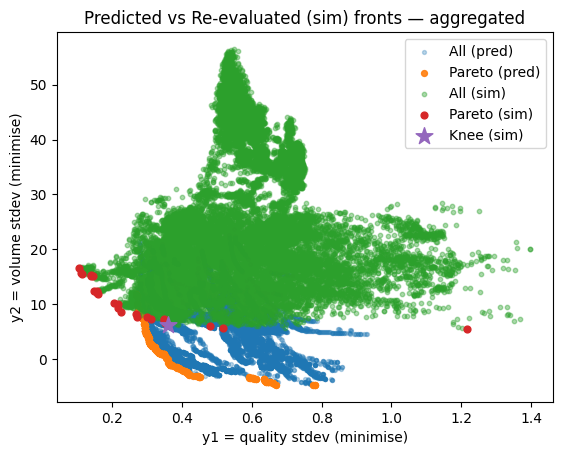

Saved: Results/figs/fronts_pred_vs_sim_aggregated.png


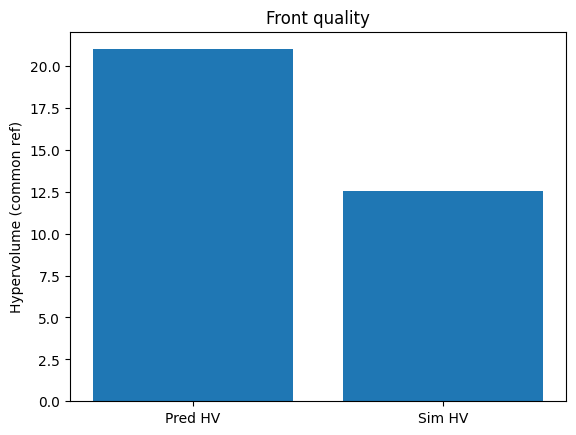

Saved: Results/figs/hv_bar_common_ref.png
[preview] HV values: {'Pred HV': 21.005942866128372, 'Sim HV': 12.55623820095756}


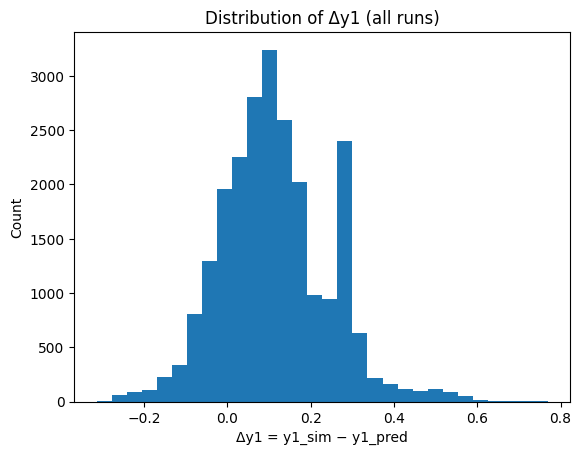

Saved: Results/figs/delta_y1_hist.png


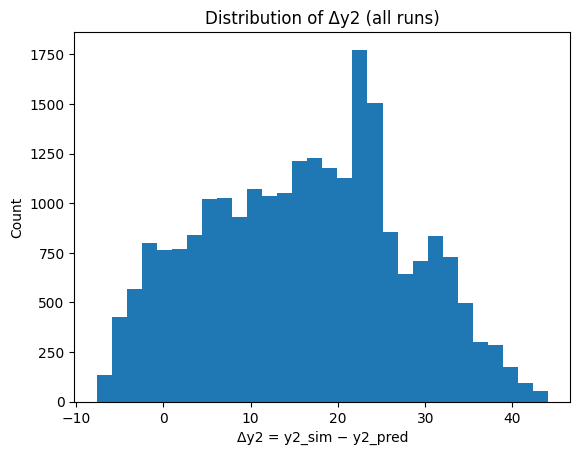

Saved: Results/figs/delta_y2_hist.png


/var/folders/gx/j5mlrwx101sggjptt_v7g6sw0000gn/T/ipykernel_81236/2041222001.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot([sens[c] for c in cols], labels=[c.split("_",1)[1] for c in cols])


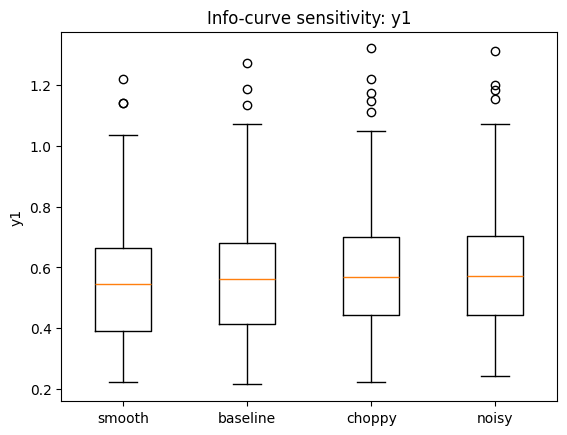

Saved: Results/figs/sensitivity_y1_box.png


/var/folders/gx/j5mlrwx101sggjptt_v7g6sw0000gn/T/ipykernel_81236/2041222001.py:147: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot([sens[c] for c in cols], labels=[c.split("_",1)[1] for c in cols])


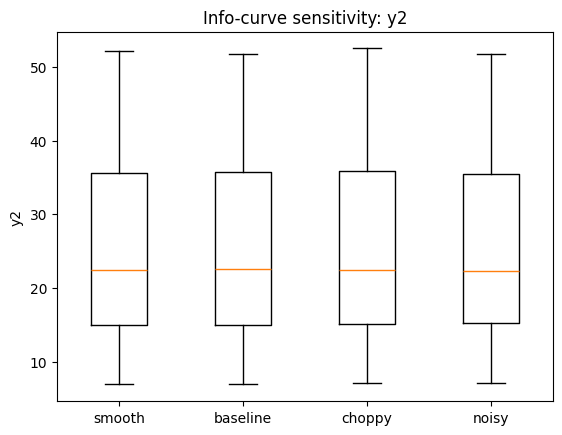

Saved: Results/figs/sensitivity_y2_box.png


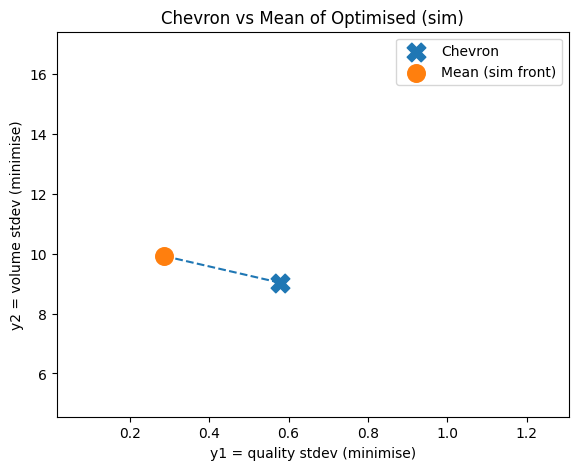

Saved: Results/figs/chevron_vs_mean_sim.png


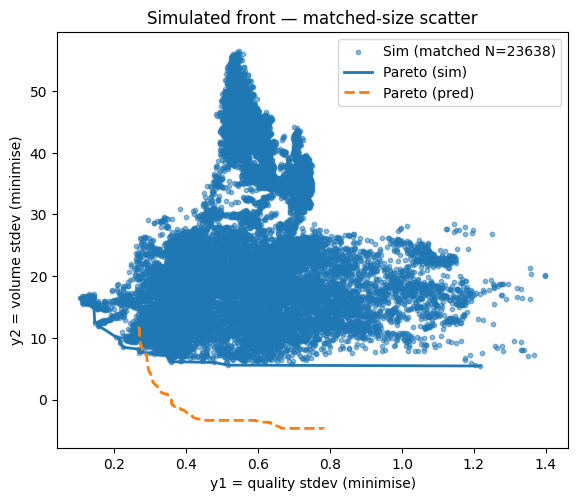

Saved: Results/figs/fronts_sim_matched_count.png


In [ ]:
# CELL — Figures (aggregated fronts, HV bar, deltas, sensitivity, Chevron)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Figure output dir (use FIG from Cell A; fall back if missing)
try:
    OUT_FIG = FIG
except NameError:
    OUT_FIG = Path("Results/figs"); OUT_FIG.mkdir(parents=True, exist_ok=True)

# Source list: prefer files_all (from Cell B); else scan re-eval dir
try:
    files_list = files_all
except NameError:
    try:
        files_list = [str(p) for p in DST.glob("front_sim_*.csv")]
    except NameError:
        files_list = []

preds, sims, pairs = [], [], []
for fp in files_list:
    try:
        hdr = pd.read_csv(fp, nrows=0).columns
        if {"y1_sim","y2_sim"}.issubset(hdr):
            sims.append(pd.read_csv(fp, usecols=["y1_sim","y2_sim"]))
        if {"y1_pred","y2_pred"}.issubset(hdr):
            preds.append(pd.read_csv(fp, usecols=["y1_pred","y2_pred"]))
        if {"y1_pred","y2_pred","y1_sim","y2_sim"}.issubset(hdr):
            pairs.append(pd.read_csv(fp, usecols=["y1_pred","y2_pred","y1_sim","y2_sim"]))
    except Exception:
        continue

df_sim_all  = pd.concat(sims,  ignore_index=True) if sims  else pd.DataFrame(columns=["y1_sim","y2_sim"])
df_pred_all = pd.concat(preds, ignore_index=True) if preds else pd.DataFrame(columns=["y1_pred","y2_pred"])
df_pairs    = pd.concat(pairs, ignore_index=True) if pairs  else pd.DataFrame(columns=["y1_pred","y2_pred","y1_sim","y2_sim"])

P_sim  = df_sim_all[["y1_sim","y2_sim"]].dropna().to_numpy(dtype=float)
P_pred = df_pred_all[["y1_pred","y2_pred"]].dropna().to_numpy(dtype=float)

print(f"[preview] P_sim shape: {P_sim.shape}, P_pred shape: {P_pred.shape}")
if not df_pairs.empty:
    print("[preview] paired rows (head):")
    try:
        from IPython.display import display
        display(df_pairs.head(5))
    except Exception:
        print(df_pairs.head(5))

# ND fronts (minimization)
def _nd(F):
    if F is None or len(F) == 0: return F
    I = nd_filter(F)
    return F[I] if len(I) else F

P_sim_nd  = _nd(P_sim)  if P_sim.size  else P_sim
P_pred_nd = _nd(P_pred) if P_pred.size else P_pred

# Common reference (adaptive by default; honors USE_FIXED_REF toggle from Cell A)
ref_common = ref_point_for_hv(P_pred_nd if P_pred_nd.size else None,
                              P_sim_nd  if P_sim_nd.size  else None,
                              pad=1.05)
print(f"[preview] REF_COMMON = ({ref_common[0]:.4g}, {ref_common[1]:.4g})")

# (1) Predicted vs Sim (aggregated scatter with ND highlights and knee)
if P_sim.size or P_pred.size:
    plt.figure()
    if P_pred.size:
        plt.scatter(P_pred[:,0], P_pred[:,1], s=8,  alpha=0.3, label="All (pred)")
        if P_pred_nd.size:
            plt.scatter(P_pred_nd[:,0], P_pred_nd[:,1], s=18, alpha=0.9, label="Pareto (pred)")
    if P_sim.size:
        plt.scatter(P_sim[:,0], P_sim[:,1], s=10, alpha=0.4, label="All (sim)")
        if P_sim_nd.size:
            plt.scatter(P_sim_nd[:,0], P_sim_nd[:,1], s=24, label="Pareto (sim)")
            if len(P_sim_nd) > 2:
                kp = knee_point(P_sim_nd)
                if kp is not None:
                    plt.scatter([kp[0]],[kp[1]], marker="*", s=160, label="Knee (sim)")
    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("Predicted vs Re-evaluated (sim) fronts — aggregated")
    plt.legend()
    out = OUT_FIG / "fronts_pred_vs_sim_aggregated.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
else:
    print("Skip: no points for fronts plot.")

# (2) HV bar (common reference) using pymoo HV
from pymoo.indicators.hv import HV
vals, labels = [], []
hv = HV(ref_point=ref_common)
if P_pred_nd.size:
    vals.append(float(hv(P_pred_nd))); labels.append("Pred HV")
if P_sim_nd.size:
    vals.append(float(hv(P_sim_nd)));  labels.append("Sim HV")
if vals:
    plt.figure()
    plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(vals)), labels)
    plt.ylabel("Hypervolume (common ref)")
    plt.title("Front quality")
    out = OUT_FIG / "hv_bar_common_ref.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
    print("[preview] HV values:", {lab: float(v) for lab, v in zip(labels, vals)})

# (3) Δ histograms (sim - pred) across all paired rows
if not df_pairs.empty:
    m = df_pairs.dropna()
    dy1 = (m["y1_sim"] - m["y1_pred"]).to_numpy(dtype=float)
    dy2 = (m["y2_sim"] - m["y2_pred"]).to_numpy(dtype=float)
    if dy1.size:
        plt.figure(); plt.hist(dy1, bins=30)
        plt.xlabel("Δy1 = y1_sim − y1_pred"); plt.ylabel("Count"); plt.title("Distribution of Δy1 (all runs)")
        out = OUT_FIG / "delta_y1_hist.png"
        plt.savefig(out, dpi=200, bbox_inches="tight")
        plt.show(); plt.close()
        print("Saved:", out)
    if dy2.size:
        plt.figure(); plt.hist(dy2, bins=30)
        plt.xlabel("Δy2 = y2_sim − y2_pred"); plt.ylabel("Count"); plt.title("Distribution of Δy2 (all runs)")
        out = OUT_FIG / "delta_y2_hist.png"
        plt.savefig(out, dpi=200, bbox_inches="tight")
        plt.show(); plt.close()
        print("Saved:", out)

# (4) Sensitivity boxplots (requires `sens`)
if "sens" in globals():
    if any(c.startswith("y1_") for c in sens.columns):
        cols = [c for c in ["y1_smooth","y1_baseline","y1_choppy","y1_noisy"] if c in sens.columns]
        if cols:
            plt.figure(); plt.boxplot([sens[c] for c in cols], labels=[c.split("_",1)[1] for c in cols])
            plt.ylabel("y1"); plt.title("Info-curve sensitivity: y1")
            out = OUT_FIG / "sensitivity_y1_box.png"
            plt.savefig(out, dpi=200, bbox_inches="tight")
            plt.show(); plt.close()
            print("Saved:", out)
    if any(c.startswith("y2_") for c in sens.columns):
        cols = [c for c in ["y2_smooth","y2_baseline","y2_choppy","y2_noisy"] if c in sens.columns]
        if cols:
            plt.figure(); plt.boxplot([sens[c] for c in cols], labels=[c.split("_",1)[1] for c in cols])
            plt.ylabel("y2"); plt.title("Info-curve sensitivity: y2")
            out = OUT_FIG / "sensitivity_y2_box.png"
            plt.savefig(out, dpi=200, bbox_inches="tight")
            plt.show(); plt.close()
            print("Saved:", out)

# (5) Chevron vs optimised — mean of simulated (prefer ND front) vs Chevron
if P_sim.size and "chev_point" in globals():
    # Use ND sim front if we have it; otherwise use all sim points
    P_ref = P_sim_nd if (P_sim_nd.size) else P_sim
    mean_sim = np.nanmean(P_ref, axis=0)
    chev = np.array(chev_point, float)

    plt.figure(figsize=(6.6, 5.0))
    plt.scatter([chev[0]],     [chev[1]],     marker="X", s=180, label="Chevron", zorder=3)
    plt.scatter([mean_sim[0]], [mean_sim[1]], marker="o", s=160, label="Mean (sim front)", zorder=3)
    plt.plot([chev[0], mean_sim[0]], [chev[1], mean_sim[1]], ls="--", lw=1.5, zorder=2)

    # tight limits around both points (slight padding); include P_ref extent if available
    try:
        arr = np.vstack([P_ref, chev.reshape(1, 2), mean_sim.reshape(1, 2)])
    except Exception:
        arr = np.vstack([chev.reshape(1, 2), mean_sim.reshape(1, 2)])
    lo = arr.min(axis=0); hi = arr.max(axis=0)
    pad = 0.08 * (np.maximum(hi - lo, 1e-12))
    plt.xlim(lo[0] - pad[0], hi[0] + pad[0])
    plt.ylim(lo[1] - pad[1], hi[1] + pad[1])

    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("Chevron vs Mean of Optimised (sim)")
    plt.legend()
    out = OUT_FIG / "chevron_vs_mean_sim.png"
    plt.savefig(out, dpi=220, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
else:
    print("Chevron mean plot skipped (need P_sim and chev_point).")

# (6) Simulated scatter with matched count (same N as the comparison set)
# try to match the number of points to All(pred) first; if not available,
# match to Pareto(pred), else Pareto(sim). Finally cap to 2k as a safety.
def _choose_target_n():
    if P_pred.size:
        return int(len(P_pred))
    if P_pred_nd.size:
        return int(len(P_pred_nd))
    if P_sim_nd.size:
        return int(len(P_sim_nd))
    return min(int(len(P_sim)), 2000)

if P_sim.size:
    target_n = _choose_target_n()
    target_n = max(1, min(target_n, len(P_sim)))  # clamp
    rng = np.random.default_rng(123)
    if len(P_sim) > target_n:
        idx = rng.choice(len(P_sim), size=target_n, replace=False)
        P_sim_match = P_sim[idx]
    else:
        P_sim_match = P_sim

    plt.figure(figsize=(6.6, 5.4))
    plt.scatter(P_sim_match[:,0], P_sim_match[:,1], s=10, alpha=0.5,
                label=f"Sim (matched N={len(P_sim_match)})")
    # Optional: overlay the ND lines so context is preserved
    if P_sim_nd.size:
        Pn = P_sim_nd[np.argsort(P_sim_nd[:,0])]
        plt.plot(Pn[:,0], Pn[:,1], lw=2, label="Pareto (sim)")
    if P_pred_nd.size:
        Pn = P_pred_nd[np.argsort(P_pred_nd[:,0])]
        plt.plot(Pn[:,0], Pn[:,1], lw=2, ls="--", label="Pareto (pred)")
    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("Simulated front — matched-size scatter")
    plt.legend()
    out = OUT_FIG / "fronts_sim_matched_count.png"
    plt.savefig(out, dpi=220, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
else:
    print("Skip: no simulated points for matched-size plot.")



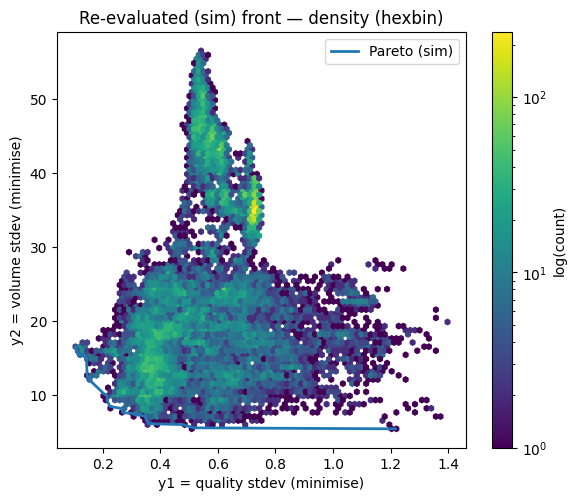

Saved: Results/figs/fronts_sim_cloud_hexbin.png


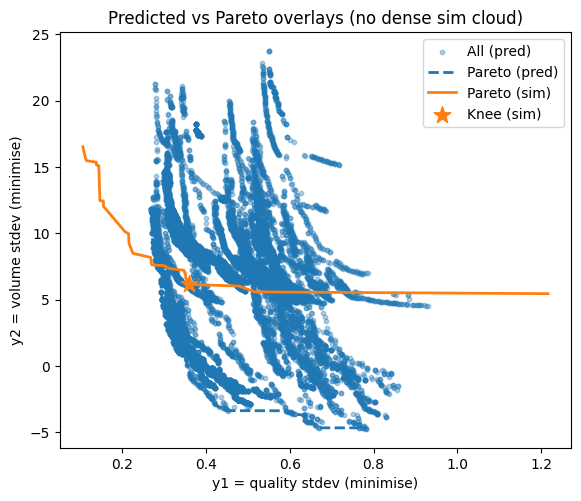

Saved: Results/figs/fronts_pred_and_nd_overlays.png


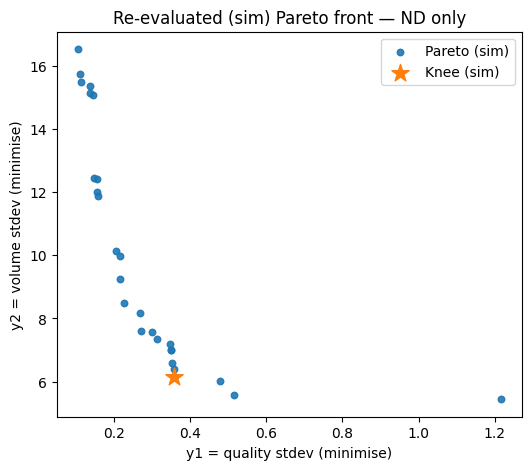

Saved: Results/figs/fronts_sim_pareto_only.png


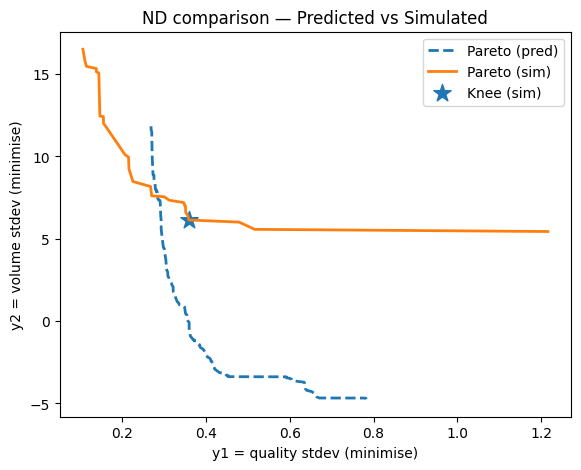

Saved: Results/figs/fronts_nd_pred_vs_sim.png


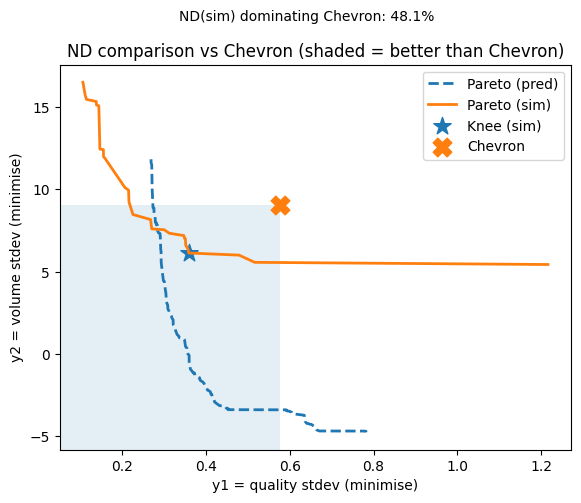

Saved: Results/figs/fronts_nd_vs_chevron.png


In [ ]:
# (1a) Simulated cloud only (23k pts) — HEXBIN + optional Pareto(sim) line
if P_sim.size:
    plt.figure(figsize=(6.6, 5.4))
    hb = plt.hexbin(P_sim[:, 0], P_sim[:, 1], gridsize=80, bins="log", mincnt=1)
    plt.colorbar(hb, label="log(count)")
    if P_sim_nd.size:
        Pn = P_sim_nd[np.argsort(P_sim_nd[:, 0])]
        plt.plot(Pn[:, 0], Pn[:, 1], lw=2, label="Pareto (sim)")
    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("Re-evaluated (sim) front — density (hexbin)")
    plt.legend()
    out = OUT_FIG / "fronts_sim_cloud_hexbin.png"
    plt.savefig(out, dpi=220, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
else:
    print("Skip: no simulated points for sim-cloud plot.")

# (1b) Overlays only — All(pred) + Pareto(pred) + Pareto(sim) + Knee(sim)
if P_pred.size or P_sim_nd.size or P_pred_nd.size:
    plt.figure(figsize=(6.6, 5.4))
    if P_pred.size:
        plt.scatter(P_pred[:, 0], P_pred[:, 1], s=10, alpha=0.35, label="All (pred)")
    if P_pred_nd.size:
        Pn = P_pred_nd[np.argsort(P_pred_nd[:, 0])]
        plt.plot(Pn[:, 0], Pn[:, 1], lw=2, ls="--", label="Pareto (pred)")
    if P_sim_nd.size:
        Pn = P_sim_nd[np.argsort(P_sim_nd[:, 0])]
        plt.plot(Pn[:, 0], Pn[:, 1], lw=2, label="Pareto (sim)")
        if len(P_sim_nd) > 2:
            kp = knee_point(P_sim_nd)
            if kp is not None:
                plt.scatter([kp[0]], [kp[1]], marker="*", s=160, label="Knee (sim)")
    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("Predicted vs Pareto overlays (no dense sim cloud)")
    plt.legend()
    out = OUT_FIG / "fronts_pred_and_nd_overlays.png"
    plt.savefig(out, dpi=220, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
else:
    print("Skip: nothing to plot for overlays.")
    
# (1c) ND-only — simulated Pareto front (clean)
if P_sim_nd.size:
    plt.figure(figsize=(6.0, 5.0))
    Pn = P_sim_nd[np.argsort(P_sim_nd[:, 0])]

    # thin if extremely large
    if len(Pn) > 10000:
        sel = np.linspace(0, len(Pn) - 1, 10000).astype(int)
        Pn = Pn[sel]

    plt.scatter(Pn[:, 0], Pn[:, 1], s=22, alpha=0.9, label="Pareto (sim)")

    # Knee overlay if available
    if len(P_sim_nd) > 2:
        kp = knee_point(P_sim_nd)
        if kp is not None:
            plt.scatter([kp[0]], [kp[1]], marker="*", s=170, label="Knee (sim)")

    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("Re-evaluated (sim) Pareto front — ND only")
    plt.legend()
    out = OUT_FIG / "fronts_sim_pareto_only.png"
    plt.savefig(out, dpi=220, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
else:
    print("Skip: no simulated ND points for ND-only plot.")
    
# (1d) ND comparison — Pareto(pred) vs Pareto(sim) + Knee(sim)
if (P_sim_nd.size if isinstance(P_sim_nd, np.ndarray) else 0) or (P_pred_nd.size if isinstance(P_pred_nd, np.ndarray) else 0):
    plt.figure(figsize=(6.6, 5.0))

    # Pareto (pred) dashed
    if P_pred_nd.size:
        Pp = P_pred_nd[np.argsort(P_pred_nd[:, 0])]
        # optional thinning for very long fronts
        if len(Pp) > 5000:
            sel = np.linspace(0, len(Pp) - 1, 5000).astype(int)
            Pp = Pp[sel]
        plt.plot(Pp[:, 0], Pp[:, 1], lw=2, ls="--", label="Pareto (pred)")

    # Pareto (sim) solid + knee
    if P_sim_nd.size:
        Ps = P_sim_nd[np.argsort(P_sim_nd[:, 0])]
        if len(Ps) > 5000:
            sel = np.linspace(0, len(Ps) - 1, 5000).astype(int)
            Ps = Ps[sel]
        plt.plot(Ps[:, 0], Ps[:, 1], lw=2, label="Pareto (sim)")
        if len(P_sim_nd) > 2:
            kp = knee_point(P_sim_nd)
            if kp is not None:
                plt.scatter([kp[0]], [kp[1]], marker="*", s=170, label="Knee (sim)")

    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("ND comparison — Predicted vs Simulated")
    plt.legend()
    out = OUT_FIG / "fronts_nd_pred_vs_sim.png"
    plt.savefig(out, dpi=220, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
else:
    print("Skip: no ND sets available for comparison.")

    # --- Shade "better than knee" (lower-left) region ---
    ax = plt.gca()
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # use the same knee computed just above
    try:
        xk, yk = float(kp[0]), float(kp[1])
        from matplotlib.patches import Rectangle
        better_rect = Rectangle(
            (xmin, ymin),              # bottom-left corner
            max(0.0, xk - xmin),       # width
            max(0.0, yk - ymin),       # height
            facecolor="tab:green", alpha=0.12, edgecolor=None, zorder=0
        )
        ax.add_patch(better_rect)
        ax.annotate("Better than Knee (sim)",
                    (xmin + 0.02*(xk - xmin), ymin + 0.85*(yk - ymin)),
                    color="tab:green")
        # keep original limits (adding a patch can change autoscale)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    except Exception:
        pass

# (1e) Chevron referenced ND comparison — shade "better than Chevron"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# need a Chevron point (xc, yc) computed earlier
if "chev_point" in globals() and (P_sim_nd.size or P_pred_nd.size):
    xc, yc = float(chev_point[0]), float(chev_point[1])

    plt.figure(figsize=(6.6, 5.0))

    # Pareto (pred) — dashed
    if P_pred_nd.size:
        Pp = P_pred_nd[np.argsort(P_pred_nd[:, 0])]
        if len(Pp) > 5000:
            sel = np.linspace(0, len(Pp) - 1, 5000).astype(int)
            Pp = Pp[sel]
        plt.plot(Pp[:, 0], Pp[:, 1], lw=2, ls="--", label="Pareto (pred)")

    # Pareto (sim) — solid + knee
    if P_sim_nd.size:
        Ps = P_sim_nd[np.argsort(P_sim_nd[:, 0])]
        if len(Ps) > 5000:
            sel = np.linspace(0, len(Ps) - 1, 5000).astype(int)
            Ps = Ps[sel]
        plt.plot(Ps[:, 0], Ps[:, 1], lw=2, label="Pareto (sim)")
        if len(P_sim_nd) > 2:
            kp = knee_point(P_sim_nd)
            if kp is not None:
                plt.scatter([kp[0]], [kp[1]], marker="*", s=170, label="Knee (sim)")

    # Chevron marker
    plt.scatter([xc], [yc], marker="X", s=180, label="Chevron")

    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("ND comparison vs Chevron (shaded = better than Chevron)")

    # Shade "better than Chevron" region (lower left of Chevron)
    ax = plt.gca()
    # draw first to let autoscale set nice limits
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    rect = Rectangle(
        (xmin, ymin),
        max(0.0, xc - xmin),
        max(0.0, yc - ymin),
        facecolor="tab:blue",
        alpha=0.12,
        edgecolor=None,
        zorder=0,
    )
    ax.add_patch(rect)
    # restore limits (patch can change autoscale)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    #show fraction of ND(sim) dominating Chevron in the subtitle
    try:
        def _dom(a, b):
            return (a[0] <= b[0] and a[1] <= b[1]) and (a[0] < b[0] or a[1] < b[1])
        frac = float(np.mean([_dom(p, (xc, yc)) for p in P_sim_nd])) if P_sim_nd.size else np.nan
        plt.suptitle(f"ND(sim) dominating Chevron: {frac:.1%}", y=0.99, fontsize=10)
    except Exception:
        pass

    plt.legend()
    out = OUT_FIG / "fronts_nd_vs_chevron.png"
    plt.savefig(out, dpi=220, bbox_inches="tight")
    plt.show(); plt.close()
    print("Saved:", out)
else:
    print("Skip: need chev_point and at least one ND set to plot.")


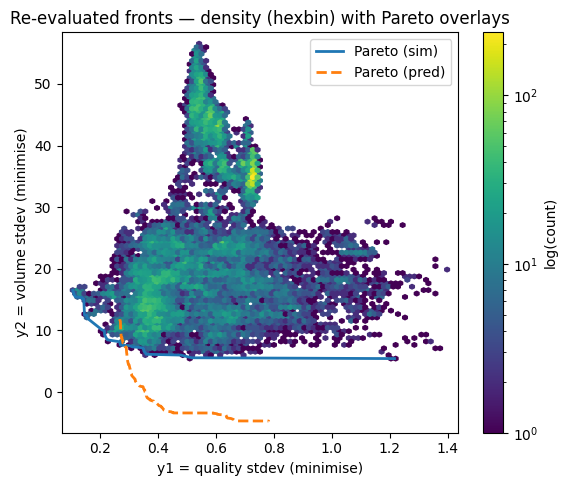

Saved: Results/figs/fronts_sim_hexbin_with_nd.png


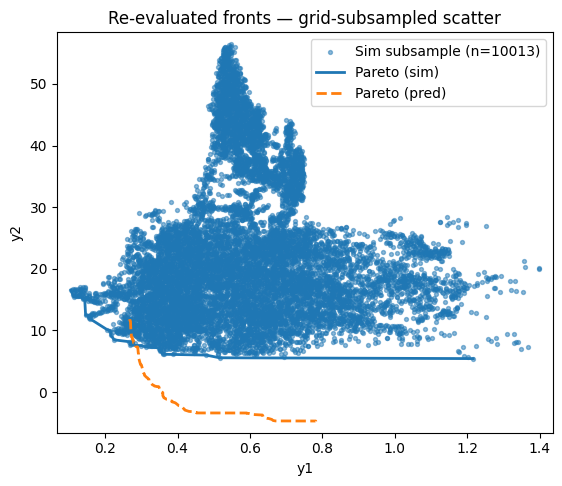

Saved: Results/figs/fronts_sim_subsample_with_nd.png


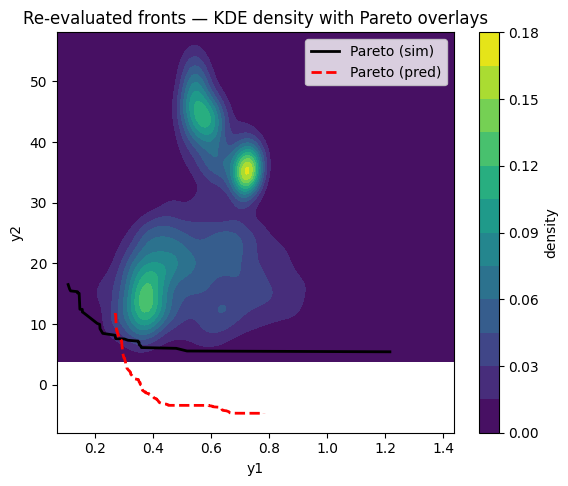

Saved: Results/figs/fronts_sim_kde_with_nd.png


In [ ]:
# === Better visuals for huge fronts ===
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Helper 1: grid based subsample (uniform across the objective space)
def grid_subsample(F, bins=120, max_per_bin=3, seed=42):
    F = np.asarray(F, float)
    if len(F) == 0: return F
    rng = np.random.default_rng(seed)
    fmin = F.min(axis=0); fmax = F.max(axis=0)
    span = np.maximum(fmax - fmin, 1e-12)
    IJ = np.floor((F - fmin) / span * bins).astype(int)
    IJ = np.clip(IJ, 0, bins-1)
    keep = []
    # sample at most max_per_bin per 2D bin
    # (vectorized grouping via structured array)
    keys = IJ[:,0] * bins + IJ[:,1]
    order = np.argsort(keys)
    keys_sorted = keys[order]
    splits = np.flatnonzero(np.diff(keys_sorted)) + 1
    groups = np.split(order, splits)
    for g in groups:
        if len(g) <= max_per_bin:
            keep.extend(g.tolist())
        else:
            keep.extend(rng.choice(g, size=max_per_bin, replace=False).tolist())
    return F[np.array(keep)]

# Helper 2: nice plot bounds with padding
def _lims(Fs, pad=0.03):
    if not Fs: return None
    cat = np.vstack([f for f in Fs if f is not None and len(f)])
    lo = cat.min(axis=0); hi = cat.max(axis=0)
    d = np.maximum(hi - lo, 1e-12)
    return (lo[0]-pad*d[0], hi[0]+pad*d[0], lo[1]-pad*d[1], hi[1]+pad*d[1])

# === A) HEXBIN density + ND overlay ===
if P_sim.size:
    plt.figure(figsize=(6.4, 5.2))
    hb = plt.hexbin(P_sim[:,0], P_sim[:,1], gridsize=80, bins='log', mincnt=1)
    plt.colorbar(hb, label="log(count)")
    if P_sim_nd.size:
        Pn = P_sim_nd[np.argsort(P_sim_nd[:,0])]
        plt.plot(Pn[:,0], Pn[:,1], lw=2, label="Pareto (sim)")
    if P_pred_nd.size:
        Pn = P_pred_nd[np.argsort(P_pred_nd[:,0])]
        plt.plot(Pn[:,0], Pn[:,1], lw=2, ls='--', label="Pareto (pred)")
    lims = _lims([P_sim, P_pred])
    if lims: plt.xlim(lims[0],lims[1]); plt.ylim(lims[2],lims[3])
    plt.xlabel("y1 = quality stdev (minimise)")
    plt.ylabel("y2 = volume stdev (minimise)")
    plt.title("Re-evaluated fronts — density (hexbin) with Pareto overlays")
    plt.legend()
    out = OUT_FIG / "fronts_sim_hexbin_with_nd.png"
    plt.savefig(out, dpi=220, bbox_inches="tight"); plt.show(); plt.close()
    print("Saved:", out)

# === B) Grid-subsampled scatter + ND overlay  ===
if P_sim.size:
    P_sim_sub = grid_subsample(P_sim, bins=150, max_per_bin=2, seed=7)   # ~ up to 150*150*2 worst-case, usually << 10k
    plt.figure(figsize=(6.4, 5.2))
    plt.scatter(P_sim_sub[:,0], P_sim_sub[:,1], s=8, alpha=0.5, label=f"Sim subsample (n={len(P_sim_sub)})")
    if P_sim_nd.size:
        Pn = P_sim_nd[np.argsort(P_sim_nd[:,0])]
        plt.plot(Pn[:,0], Pn[:,1], lw=2, label="Pareto (sim)")
    if P_pred_nd.size:
        Pn = P_pred_nd[np.argsort(P_pred_nd[:,0])]
        plt.plot(Pn[:,0], Pn[:,1], lw=2, ls='--', label="Pareto (pred)")
    lims = _lims([P_sim, P_pred])
    if lims: plt.xlim(lims[0],lims[1]); plt.ylim(lims[2],lims[3])
    plt.xlabel("y1"); plt.ylabel("y2")
    plt.title("Re-evaluated fronts — grid-subsampled scatter")
    plt.legend()
    out = OUT_FIG / "fronts_sim_subsample_with_nd.png"
    plt.savefig(out, dpi=220, bbox_inches="tight"); plt.show(); plt.close()
    print("Saved:", out)

# === C) Smooth density contour (KDE) + ND overlay ===
try:
    from scipy.stats import gaussian_kde
    if P_sim.size:
        # KDE over a mesh
        x = P_sim[:,0]; y = P_sim[:,1]
        xmin,xmax,ymin,ymax = _lims([P_sim]) or (x.min(),x.max(),y.min(),y.max())
        xx, yy = np.meshgrid(
            np.linspace(xmin, xmax, 200),
            np.linspace(ymin, ymax, 200)
        )
        kde = gaussian_kde(np.vstack([x, y]))
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

        plt.figure(figsize=(6.4, 5.2))
        cs = plt.contourf(xx, yy, zz, levels=12)
        plt.colorbar(cs, label="density")
        if P_sim_nd.size:
            Pn = P_sim_nd[np.argsort(P_sim_nd[:,0])]
            plt.plot(Pn[:,0], Pn[:,1], lw=2, color='k', label="Pareto (sim)")
        if P_pred_nd.size:
            Pn = P_pred_nd[np.argsort(P_pred_nd[:,0])]
            plt.plot(Pn[:,0], Pn[:,1], lw=2, ls='--', color='r', label="Pareto (pred)")
        plt.xlabel("y1"); plt.ylabel("y2")
        plt.title("Re-evaluated fronts — KDE density with Pareto overlays")
        plt.legend()
        out = OUT_FIG / "fronts_sim_kde_with_nd.png"
        plt.savefig(out, dpi=220, bbox_inches="tight"); plt.show(); plt.close()
        print("Saved:", out)
except Exception as e:
    print("[info] KDE figure skipped:", e)


## Visuals

[preview] runs metrics shape: (235, 14) from: Results/analysis/results_metrics_by_run.csv


,model,pop,evals,nvars,curve,seed,n_points,hv_pred,hv_sim,hv_drop,igd_pred_to_sim,shift_mean,ref1,ref2
0,lstm,50,10000,10.0,3,1,50,0.348852,1.129123,-0.780271,2.661624,5.473595,0.488265,19.725721
1,lstm,50,10000,10.0,6,1,50,0.338898,1.082969,-0.744071,2.910173,5.450964,0.488831,19.442204
2,lstm,50,15000,15.0,1,1,50,4.441403,0.779284,3.662119,7.642126,15.433371,0.761692,26.268307
3,lstm,100,15000,15.0,2,1,100,3.817179,0.648250,3.168929,6.582636,15.058985,0.765778,24.187720
4,lstm,100,15000,15.0,6,1,100,3.824203,0.625354,3.198849,6.930622,15.078526,0.757214,24.523137
5,lstm,50,20000,20.0,4,1,50,0.077478,0.304264,-0.226786,0.207146,25.278235,0.488655,13.927210
6,lstm,50,20000,NaN,1,1,50,0.278429,0.353257,-0.074828,2.849852,25.430338,0.488655,17.677262
7,lstm,50,20000,NaN,2,1,50,0.185350,0.330647,-0.145297,1.175987,25.386492,0.488655,15.940261


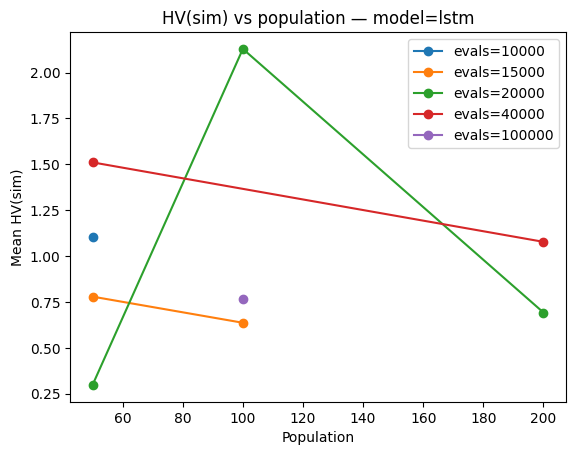

Saved: Results/figs/hv_vs_pop_model_lstm.png


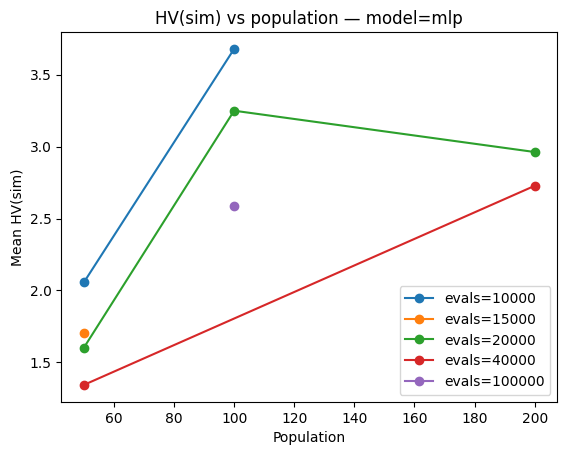

Saved: Results/figs/hv_vs_pop_model_mlp.png


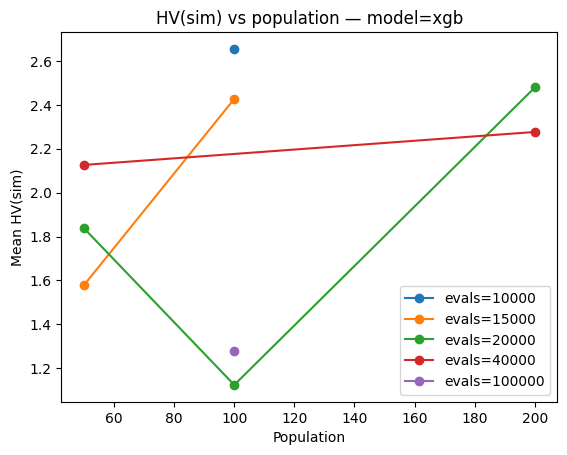

Saved: Results/figs/hv_vs_pop_model_xgb.png
[preview] knees shape: (183, 9) from: Results/analysis/results_knees_by_run.csv


,model,pop,evals,nvars,curve,seed,knee_y1,knee_y2,n_points
0,lstm,50,10000,10.0,3,1,0.384592,15.048101,8
1,lstm,50,10000,10.0,6,1,0.393739,15.639444,9
2,lstm,50,15000,15.0,1,1,0.688058,19.869150,4
3,lstm,100,15000,15.0,2,1,0.683243,19.739913,6
4,lstm,100,15000,15.0,6,1,0.684130,18.390566,3
5,lstm,100,20000,20.0,2,1,0.567713,36.350971,17
6,lstm,100,20000,20.0,4,1,0.564072,36.280496,18
7,lstm,100,20000,NaN,1,1,0.562707,36.232513,18


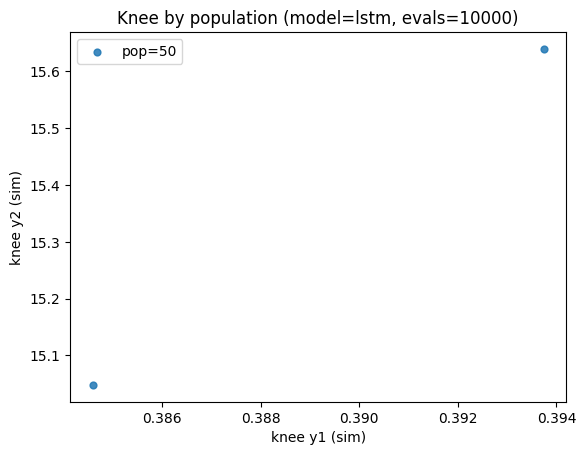

Saved: Results/figs/knee_scatter_model_lstm_evals_10000.png


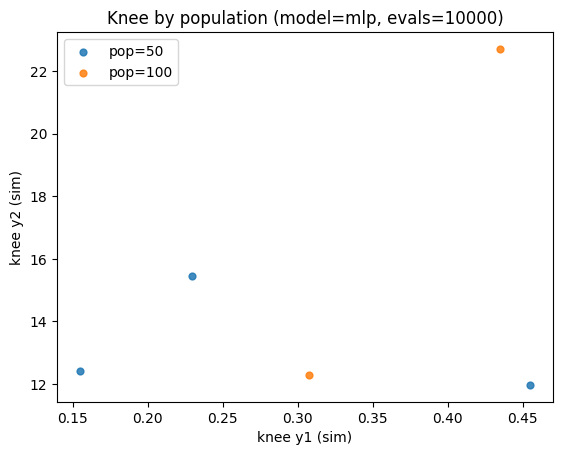

Saved: Results/figs/knee_scatter_model_mlp_evals_10000.png


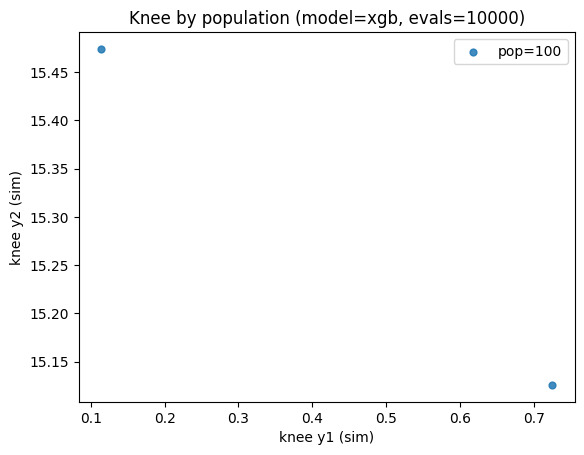

Saved: Results/figs/knee_scatter_model_xgb_evals_10000.png
[preview] example file: front_sim_front_modellstm_pop100_evals20000_curve1_run4.csv | P_pred: (100, 2), P_sim: (100, 2)


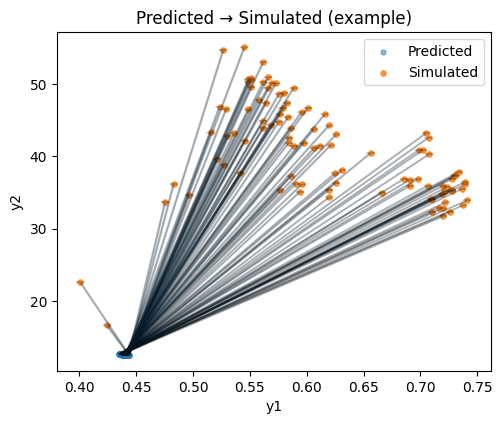

Saved: Results/figs/pred_vs_sim_front_sim_front_modellstm_pop100_evals20000_curve1_run4.png


In [ ]:
# CELL G — Example summary figures (HV vs pop, knees, and one file Pred→Sim arrows)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Paths (new first, legacy fallback) ---
try:
    OUT_FIG = FIG
except NameError:
    OUT_FIG = Path("Results/figs"); OUT_FIG.mkdir(parents=True, exist_ok=True)

# -------- HV(sim) vs population per eval budget and model --------
# Load per run metrics
try:
    runs_path = ANL / "results_metrics_by_run.csv"
    dfm = pd.read_csv(runs_path)
except Exception:
    runs_path = Path(RESULTS_DIR) / "results_runs_metrics.csv"
    dfm = pd.read_csv(runs_path)

print("[preview] runs metrics shape:", dfm.shape, "from:", runs_path)
try:
    from IPython.display import display
    display(dfm.head(8))
except Exception:
    print(dfm.head(8))

if not dfm.empty and {"model","pop","evals","hv_sim"}.issubset(dfm.columns):
    for m in sorted(dfm["model"].dropna().unique()):
        sub = dfm[dfm["model"] == m]
        plt.figure()
        for E in sorted(sub["evals"].dropna().unique()):
            s2 = sub[sub["evals"] == E]
            xs, ys = [], []
            for P in sorted(s2["pop"].dropna().unique()):
                xs.append(P)
                ys.append(np.nanmean(s2.loc[s2["pop"] == P, "hv_sim"].to_numpy(dtype=float)))
            if xs:
                plt.plot(xs, ys, marker='o', label=f"evals={int(E)}")
        plt.title(f"HV(sim) vs population — model={m}")
        plt.xlabel("Population"); plt.ylabel("Mean HV(sim)"); plt.legend()
        out = OUT_FIG / f"hv_vs_pop_model_{m}.png"
        plt.savefig(out, dpi=200, bbox_inches='tight')
        plt.show(); plt.close()
        print("Saved:", out)
else:
    print("[info] Skipping HV(sim) vs pop plot (missing columns).")

# -------- Knee scatter (per model, pick one eval budget for view) --------
# Load knees
try:
    knees_path = ANL / "results_knees_by_run.csv"
    knees = pd.read_csv(knees_path)
except Exception:
    knees_path = Path(RESULTS_DIR) / "results_knees_by_run.csv"
    knees = pd.read_csv(knees_path)

print("[preview] knees shape:", knees.shape, "from:", knees_path)
try:
    from IPython.display import display
    display(knees.head(8))
except Exception:
    print(knees.head(8))

if not knees.empty and {"model","evals","pop","knee_y1","knee_y2"}.issubset(knees.columns):
    for m in sorted(knees["model"].dropna().unique()):
        evals_avail = sorted(knees.loc[knees["model"] == m, "evals"].dropna().unique())
        if not evals_avail:
            continue
        E_pick = evals_avail[0]
        s = knees[(knees["model"] == m) & (knees["evals"] == E_pick)]
        plt.figure()
        for P in sorted(s["pop"].dropna().unique()):
            sp = s[s["pop"] == P]
            plt.scatter(sp["knee_y1"], sp["knee_y2"], s=24, label=f"pop={int(P)}", alpha=0.85)
        plt.xlabel("knee y1 (sim)"); plt.ylabel("knee y2 (sim)")
        plt.title(f"Knee by population (model={m}, evals={int(E_pick)})"); plt.legend()
        out = OUT_FIG / f"knee_scatter_model_{m}_evals_{int(E_pick)}.png"
        plt.savefig(out, dpi=200, bbox_inches='tight')
        plt.show(); plt.close()
        print("Saved:", out)
else:
    print("[info] Skipping knee scatter (missing columns).")

# -------- One example file: Pred vs Sim with arrows & knee --------
# Choose source files
try:
    files_list = files_all
except NameError:
    try:
        files_list = [str(p) for p in DST.glob("front_sim_*.csv")]
    except NameError:
        files_list = []

picked_name = None
for f in files_list:
    try:
        df = pd.read_csv(f)
    except Exception:
        continue

    if {'y1_pred','y2_pred','y1_sim','y2_sim'}.issubset(df.columns):
        P_pred = df[['y1_pred','y2_pred']].to_numpy(float)
        P_sim  = df[['y1_sim','y2_sim']].to_numpy(float)

        print(f"[preview] example file: {Path(f).name} | P_pred: {P_pred.shape}, P_sim: {P_sim.shape}")

        plt.figure(figsize=(5.6, 4.4))
        plt.scatter(P_pred[:,0], P_pred[:,1], s=12, alpha=0.5, label='Predicted')
        plt.scatter(P_sim[:,0],  P_sim[:,1],  s=14, alpha=0.8, label='Simulated')

        # Arrows (only if 1–1 pairs)
        if len(P_pred) == len(P_sim) and len(P_pred) > 0:
            # scale head width relative to axis range
            ax = plt.gca()
            dx = (P_sim[:,0].max() - P_sim[:,0].min() + 1e-9)
            head_w = 0.02 * dx
            for (a, b) in zip(P_pred, P_sim):
                plt.arrow(a[0], a[1], (b[0]-a[0]), (b[1]-a[1]),
                          length_includes_head=True, head_width=head_w, alpha=0.25)

        # ND + knee (uses helpers from Cell A)
        if len(P_sim) > 2:
            I = nd_filter(P_sim)
            P_sim_nd = P_sim[I] if len(I) else P_sim
            kp = knee_point(P_sim_nd)
            if kp is not None:
                plt.scatter([kp[0]], [kp[1]], marker='*', s=160, label='Knee (sim)')

        plt.xlabel('y1'); plt.ylabel('y2'); plt.title('Predicted → Simulated (example)'); plt.legend()
        out = OUT_FIG / f"pred_vs_sim_{Path(f).stem}.png"
        plt.savefig(out, dpi=220, bbox_inches='tight')
        plt.show(); plt.close()
        print("Saved:", out)
        picked_name = Path(f).name
        break

if picked_name is None:
    print("[info] No single file contained both predicted and simulated columns for the example plot.")


# Summary Figures

In [ ]:
# === Summary Figures (robust + skip if exists) ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Paths ----------
FIG_SUM = Path("Results/figs_summary")
FIG_SUM.mkdir(parents=True, exist_ok=True)

def _find_csv(name: str):
    """Search common result folders for a CSV and return the first hit or None."""
    for d in ["Results/analysis", "Results/sim re-eval", "Results/sim_reeval", "Results", "."]:
        p = Path(d) / name
        if p.exists():
            return p
    return None

front_shift_path = _find_csv("results_front_shift.csv")
by_setting_path  = _find_csv("results_metrics_by_setting.csv")
runs_path        = _find_csv("results_runs_metrics.csv")
boot_ci_path     = _find_csv("results_hv_bootstrap_ci.csv")  # optional

# ---------- Helpers ----------
def _fmt_int(x, prefix=""):
    if pd.isna(x):
        return f"{prefix}NA"
    try:
        return f"{prefix}{int(np.round(float(x)))}"
    except Exception:
        return f"{prefix}{x}"

def _label_mpk(row):
    # model|p<pop>|k<nvars>
    return f"{row.get('model','?')}|{_fmt_int(row.get('pop'),'p')}|{_fmt_int(row.get('nvars'),'k')}"

def _label_pek(row):
    # p<pop>|e<evals>|k<nvars>
    return f"{_fmt_int(row.get('pop'),'p')}|{_fmt_int(row.get('evals'),'e')}|{_fmt_int(row.get('nvars'),'k')}"

def _ensure_cols(df, cols=("model","pop","evals","nvars","hv_sim","hv_pred","hv_drop")):
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df

def _savefig_skip(fig, out_path: Path, dpi=200):
    """Save fig unless file already exists; always close the figure."""
    try:
        out_path = Path(out_path)
        if out_path.exists():
            print(f"[skip] {out_path} exists")
            plt.close(fig)
            return False
        fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
        plt.close(fig)
        print(f"Saved: {out_path}")
        return True
    except Exception as e:
        plt.close(fig)
        print(f"[warn] could not save {out_path}: {e}")
        return False

# ---------- 01 — HV (common ref) Pred vs Sim (bar) ----------
if front_shift_path is not None:
    try:
        d = pd.read_csv(front_shift_path)
        # Expect columns: hv_pred_common, hv_sim_common
        vals, labels = [], []
        if "hv_pred_common" in d.columns and np.isfinite(d["hv_pred_common"]).any():
            vals.append(float(d["hv_pred_common"].dropna().iloc[0] if len(d["hv_pred_common"].dropna()) else np.nan))
            labels.append("Pred HV (common ref)")
        if "hv_sim_common" in d.columns and np.isfinite(d["hv_sim_common"]).any():
            vals.append(float(d["hv_sim_common"].dropna().iloc[0] if len(d["hv_sim_common"].dropna()) else np.nan))
            labels.append("Sim HV (common ref)")

        if any(np.isfinite(v) for v in vals):
            fig = plt.figure(figsize=(6.2, 4.2))
            plt.bar(range(len(vals)), vals)
            plt.xticks(range(len(vals)), labels, rotation=0)
            plt.ylabel("Hypervolume")
            plt.title("Front quality (common reference)")
            _savefig_skip(fig, FIG_SUM / "01_hv_pred_vs_sim_common_ref.png", dpi=220)
        else:
            print("[note] 01: hv values missing in results_front_shift.csv")
    except Exception as e:
        print("[warn] 01: failed to plot HV common ref:", e)
else:
    print("[note] 01: results_front_shift.csv not found")

# ---------- 02 — HV(sim) by model (boxplot over runs) ----------
# Prefer per-run metrics if available; otherwise fall back to by setting means 
if runs_path is not None:
    try:
        df = pd.read_csv(runs_path)
        df = _ensure_cols(df)
        g = df.dropna(subset=["hv_sim", "model"])
        order = sorted([m for m in g["model"].dropna().unique()])
        if len(order) >= 1 and len(g) > 0:
            data = [g[g["model"] == m]["hv_sim"].dropna().values for m in order]
            fig = plt.figure(figsize=(max(6.0, 1.5*len(order)), 4.6))
            plt.boxplot(data, tick_labels=order, showfliers=False)  # tick_labels fixes Matplotlib 3.9 deprecation
            plt.ylabel("HV(sim)")
            plt.title("HV(sim) by model")
            _savefig_skip(fig, FIG_SUM / "02_hv_sim_box_by_model.png", dpi=220)
        else:
            print("[note] 02: not enough data in runs to make boxplot")
    except Exception as e:
        print("[warn] 02: failed to plot HV(sim) by model:", e)
elif by_setting_path is not None:
    # Fallback: bar of hv_sim_mean by model (aggregated)
    try:
        df = pd.read_csv(by_setting_path)
        df = _ensure_cols(df)
        g = df.groupby("model", dropna=False)["hv_sim_mean"].mean().dropna()
        if len(g):
            fig = plt.figure(figsize=(6.2, 4.2))
            g.plot(kind="bar")
            plt.ylabel("Mean HV(sim)")
            plt.title("HV(sim) by model (setting means)")
            _savefig_skip(fig, FIG_SUM / "02_hv_sim_box_by_model.png", dpi=220)
        else:
            print("[note] 02: not enough data in by-setting to make fallback bar")
    except Exception as e:
        print("[warn] 02: fallback bar failed:", e)
else:
    print("[note] 02: neither runs nor by-setting metrics found")

# ---------- 03 — HV(sim) vs Population, per model (lines by evals) ----------
def _hv_vs_pop_from(df_in: pd.DataFrame, out_prefix="03_hv_vs_pop_model_"):
    df_in = _ensure_cols(df_in)
    models = sorted(df_in["model"].dropna().unique())
    for m in models:
        sub = df_in[df_in["model"] == m].copy()
        # pick source columns (per run hv_sim or per-setting hv_sim_mean)
        col = "hv_sim" if "hv_sim" in sub.columns else ("hv_sim_mean" if "hv_sim_mean" in sub.columns else None)
        if col is None:
            continue
        evals_list = sorted(sub["evals"].dropna().unique())
        if len(evals_list) == 0:
            continue

        fig = plt.figure(figsize=(6.8, 4.6))
        for E in evals_list:
            s2 = sub[sub["evals"] == E]
            xs = sorted(s2["pop"].dropna().unique())
            ys = []
            for P in xs:
                vals = s2[s2["pop"] == P][col].to_numpy(float)
                vals = vals[np.isfinite(vals)]
                ys.append(np.mean(vals) if len(vals) else np.nan)
            if len(xs):
                plt.plot(xs, ys, marker='o', label=f"evals={_fmt_int(E)}")
        plt.title(f"HV(sim) vs population — model={m}")
        plt.xlabel("Population"); plt.ylabel("Mean HV(sim)")
        plt.legend()
        out = FIG_SUM / f"{out_prefix}{m}.png"
        _savefig_skip(fig, out, dpi=220)

# Prefer runs; fallback to by setting
if runs_path is not None:
    try:
        _hv_vs_pop_from(pd.read_csv(runs_path))
    except Exception as e:
        print("[warn] 03: runs-based plot failed, will try by-setting:", e)
        if by_setting_path is not None:
            try:
                _hv_vs_pop_from(pd.read_csv(by_setting_path))
            except Exception as e2:
                print("[warn] 03: by-setting fallback failed:", e2)
elif by_setting_path is not None:
    try:
        _hv_vs_pop_from(pd.read_csv(by_setting_path))
    except Exception as e:
        print("[warn] 03: by-setting plot failed:", e)
else:
    print("[note] 03: no source CSV for HV vs pop")

# ---------- 04 — HV by setting (bars) for each eval budget ----------
# Uses by setting if available; otherwise derives from runs (group mean)
def _hv_by_setting_from(df_in: pd.DataFrame, out_prefix="04_hv_by_setting_evals_"):
    df_in = _ensure_cols(df_in)
    # Choose hv column
    hv_col = "hv_sim_mean" if "hv_sim_mean" in df_in.columns else ("hv_sim" if "hv_sim" in df_in.columns else None)
    if hv_col is None:
        print("[note] 04: no hv column found")
        return

    evals_list = sorted(df_in["evals"].dropna().unique())
    for E in evals_list:
        dE = df_in[df_in["evals"] == E].copy()
        if "hv_sim" in dE.columns and hv_col == "hv_sim":
            # aggregate to setting-level mean to keep bars stable
            dE = dE.groupby(["model","pop","nvars","evals"], dropna=False)["hv_sim"].mean().reset_index()
        dE = _ensure_cols(dE)
        if len(dE) == 0:
            continue

        # Build readable labels 
        dE["label"] = dE.apply(_label_mpk, axis=1)
        dE = dE.sort_values(["model","pop","nvars"])
        xs = np.arange(len(dE))
        ys = dE[hv_col].astype(float).to_numpy()

        fig = plt.figure(figsize=(max(7.0, 0.35*len(dE)), 4.8))
        plt.bar(xs, ys)
        plt.xticks(xs, dE["label"].tolist(), rotation=90)
        plt.ylabel("HV(sim)" + (" mean" if hv_col == "hv_sim_mean" else ""))
        plt.title(f"HV by setting (evals={_fmt_int(E)})")
        out = FIG_SUM / f"{out_prefix}{_fmt_int(E).replace('e','')}.png"  # e.g., 04_hv_by_setting_evals_10000.png
        _savefig_skip(fig, out, dpi=220)

# Prefer by-setting; fallback to runs
if by_setting_path is not None:
    try:
        _hv_by_setting_from(pd.read_csv(by_setting_path))
    except Exception as e:
        print("[warn] 04: by-setting plot failed, will try runs:", e)
        if runs_path is not None:
            try:
                _hv_by_setting_from(pd.read_csv(runs_path))
            except Exception as e2:
                print("[warn] 04: runs fallback failed:", e2)
elif runs_path is not None:
    try:
        _hv_by_setting_from(pd.read_csv(runs_path))
    except Exception as e:
        print("[warn] 04: runs-based setting plot failed:", e)
else:
    print("[note] 04: no source CSV for by-setting bars")

print("[done] summary figure pipeline complete")


[skip] Results/figs_summary/01_hv_pred_vs_sim_common_ref.png exists
[skip] Results/figs_summary/02_hv_sim_box_by_model.png exists
[skip] Results/figs_summary/03_hv_vs_pop_model_lstm.png exists
[skip] Results/figs_summary/03_hv_vs_pop_model_mlp.png exists
[skip] Results/figs_summary/03_hv_vs_pop_model_xgb.png exists
[skip] Results/figs_summary/04_hv_by_setting_evals_10000.png exists
[skip] Results/figs_summary/04_hv_by_setting_evals_15000.png exists
[skip] Results/figs_summary/04_hv_by_setting_evals_20000.png exists
[skip] Results/figs_summary/04_hv_by_setting_evals_40000.png exists
[skip] Results/figs_summary/04_hv_by_setting_evals_100000.png exists
[done] summary figure pipeline complete


# Auto Gen figures

[paths] DATA_DIR = /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/analysis
[paths] OUT_DIR  = /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen
[skip] results_runs_metrics.csv not found in /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/analysis
[ok] loaded results_hv_bootstrap_ci.csv shape=(33, 8)


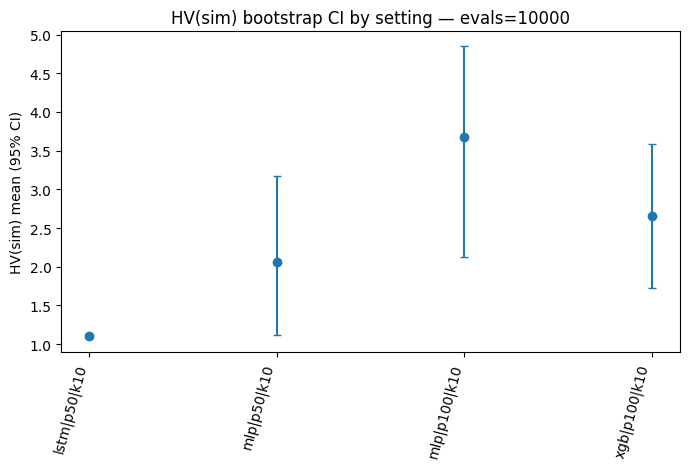

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/10_hv_bootstrap_ci_evals_10000.png


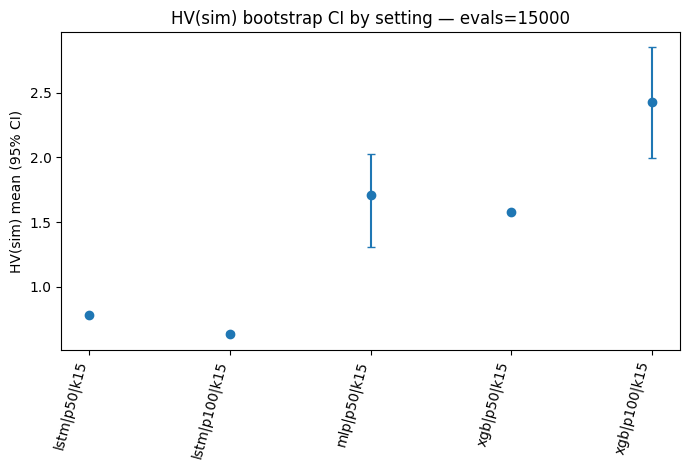

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/10_hv_bootstrap_ci_evals_15000.png


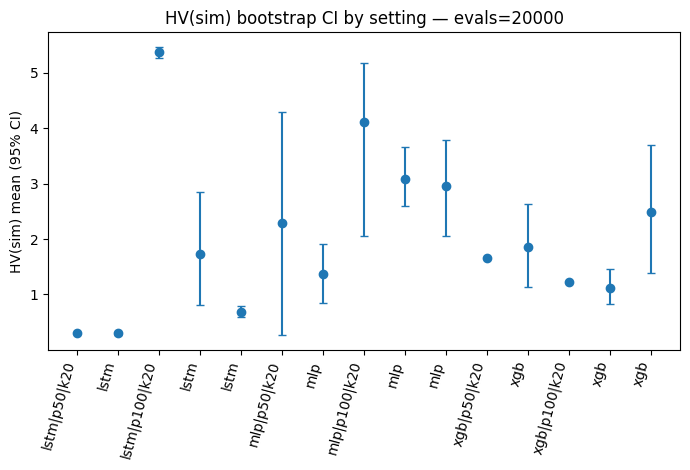

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/10_hv_bootstrap_ci_evals_20000.png


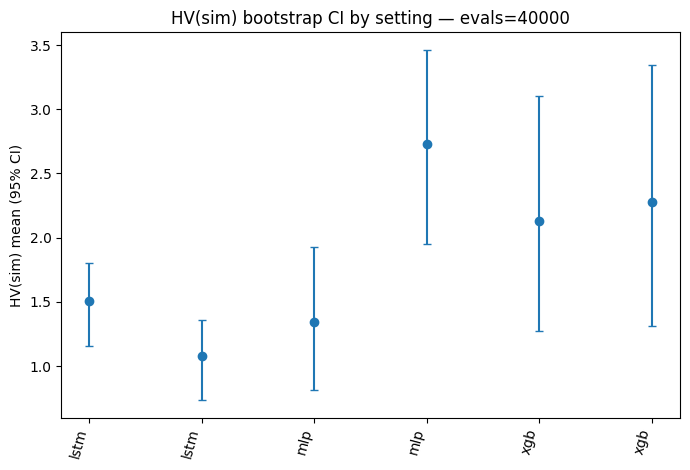

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/10_hv_bootstrap_ci_evals_40000.png


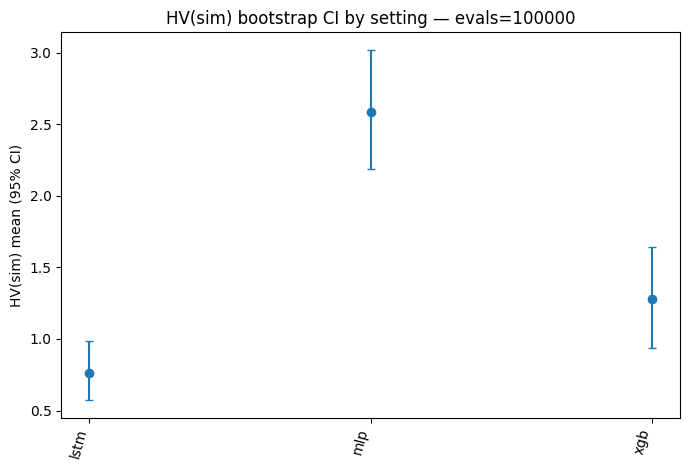

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/10_hv_bootstrap_ci_evals_100000.png
[skip] results_mlp_vs_xgb_bootstrap.csv not found in /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/analysis
[ok] loaded results_knees_by_run.csv shape=(183, 9)


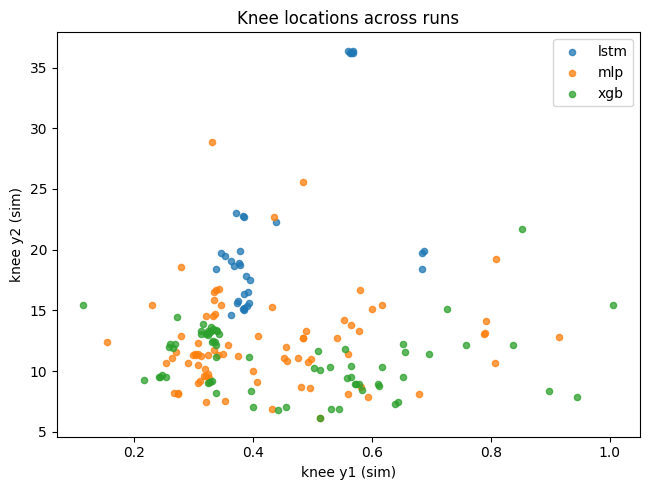

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/30_knee_scatter_all.png
[ok] loaded results_per_curve_summary.csv shape=(9, 10)


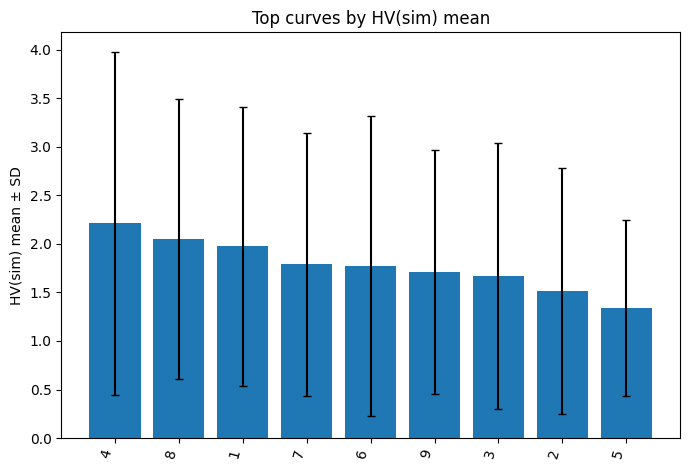

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/40_per_curve_top_hv.png
[ok] loaded results_front_shift.csv shape=(1, 7)
[front_shift] summary
    hv_pred_common  hv_sim_common  hv_delta
0       21.005943      12.556238 -8.449705


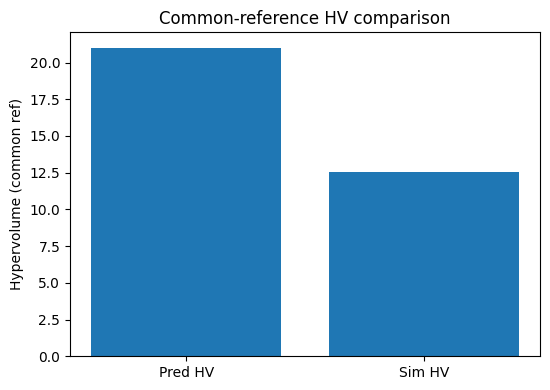

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/50_front_shift_common_ref_bar.png
[ok] loaded calibration_affine.csv shape=(6, 5)


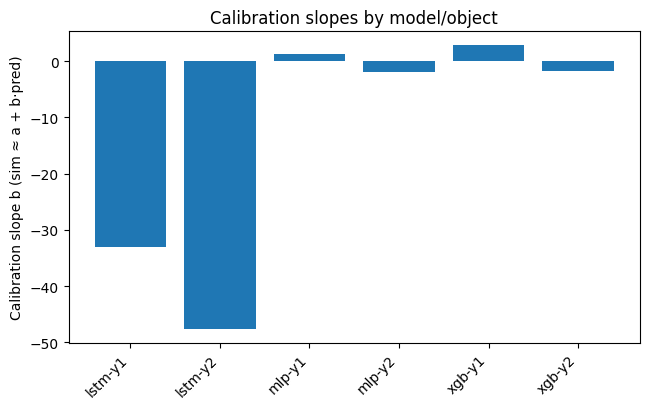

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/60_calibration_slopes.png
[ok] loaded sim_polish_sample.csv shape=(50, 11)


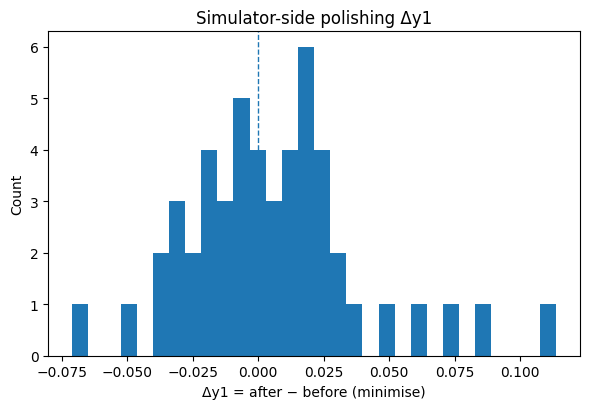

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/70_polish_delta_y1.png


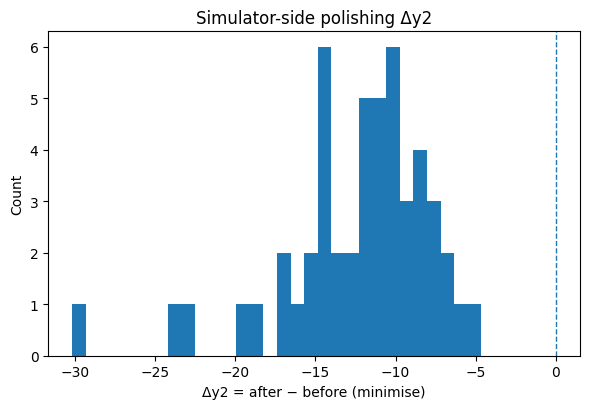

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/71_polish_delta_y2.png
[ok] loaded results_chevron_by_setting.csv shape=(235, 11)


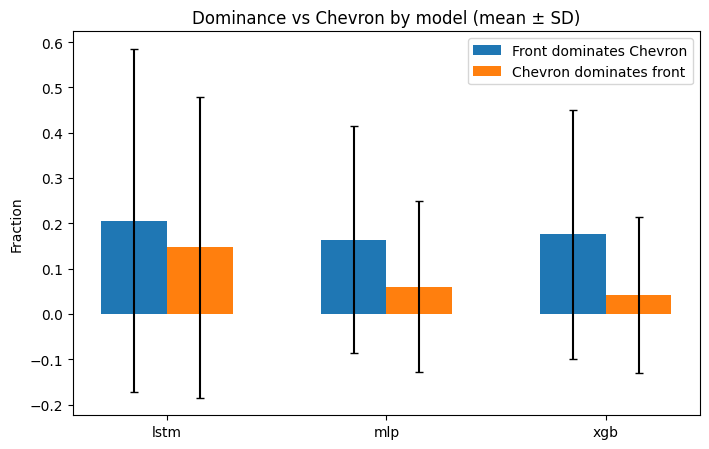

Saved: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen/80_chevron_dominance_by_model.png
[done] Auto-generation complete. Figures are in: /Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen


In [ ]:
# === Analysis plots: read CSVs from  analysis folder and auto generate figures ===
# Point this at extracted analysis directory .
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Paths ----------------
DATA_DIR = Path("/Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/analysis")
OUT_DIR  = Path("/Users/keithkumar/Desktop/Masters/Dissertation/machine-learning-eval-2025/Results/figs_analysis_autogen")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("[paths] DATA_DIR =", DATA_DIR.resolve())
print("[paths] OUT_DIR  =", OUT_DIR.resolve())

# ---------------- Utils ----------------
def _exists(name: str) -> Path | None:
    p = DATA_DIR / name
    return p if p.exists() else None

def _safe_read(name: str, **kwargs) -> pd.DataFrame | None:
    p = _exists(name)
    if p is None:
        print(f"[skip] {name} not found in {DATA_DIR}")
        return None
    try:
        df = pd.read_csv(p, **kwargs)
        print(f"[ok] loaded {name} shape={df.shape}")
        return df
    except Exception as e:
        print(f"[warn] failed to load {name}: {e}")
        return None

def _save_show(fig, outfile: Path, dpi=220):
    fig.tight_layout()
    fig.savefig(outfile, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", outfile)

def _errorbar_from_ci(ax, x, m, lo, hi, **kwargs):
    yerr = np.vstack([m-lo, hi-m])
    ax.errorbar(x, m, yerr=yerr, **kwargs)

# ---------------- 1) results_runs_metrics.csv ----------------
runs = _safe_read("results_runs_metrics.csv")
if runs is not None and not runs.empty:
    # Normalize column names/types
    for c in ["model","pop","evals","nvars"]:
        if c in runs.columns:
            
            pass

    # 1A. HV(sim) by model (all settings)
    if {"model","hv_sim"}.issubset(runs.columns):
        d = runs.dropna(subset=["model","hv_sim"])
        order = sorted(d["model"].unique())
        data = [d[d["model"]==m]["hv_sim"].to_numpy(float) for m in order]

        fig, ax = plt.subplots(figsize=(7.2, 4.6))
        ax.boxplot(data, showfliers=False)
        ax.set_xticks(range(1, len(order)+1))
        ax.set_xticklabels(order)
        ax.set_ylabel("HV(sim)")
        ax.set_title("HV(sim) by model")
        _save_show(fig, OUT_DIR / "01_hv_sim_by_model_box.png")

    # 1B. HV(sim) vs population, per model (mean ± SEM), for each evals present
    if {"model","pop","evals","hv_sim"}.issubset(runs.columns):
        for m in sorted(runs["model"].dropna().unique()):
            sub = runs[(runs["model"]==m) & runs["pop"].notna() & runs["hv_sim"].notna()]
            if sub.empty: 
                continue
            fig, ax = plt.subplots(figsize=(7.0, 4.4))
            for E in sorted(sub["evals"].dropna().unique()):
                s2 = sub[sub["evals"]==E]
                if s2.empty: 
                    continue
                pops = sorted(s2["pop"].dropna().unique())
                xs, means, sems = [], [], []
                for P in pops:
                    hv = s2[s2["pop"]==P]["hv_sim"].to_numpy(float)
                    if hv.size == 0: 
                        continue
                    xs.append(P)
                    means.append(np.nanmean(hv))
                    sems.append(np.nanstd(hv, ddof=1)/np.sqrt(max(1, hv.size)))
                if xs:
                    ax.errorbar(xs, means, yerr=sems, marker="o", capsize=3, label=f"evals={int(E)}")
            ax.set_title(f"HV(sim) vs population — model={m}")
            ax.set_xlabel("Population")
            ax.set_ylabel("Mean HV(sim) ± SEM")
            ax.legend()
            _save_show(fig, OUT_DIR / f"02_hv_vs_pop_{m}.png")

    # 1C. IGD(pred→sim) by model
    if {"model","igd_pred_to_sim"}.issubset(runs.columns):
        d = runs.dropna(subset=["model","igd_pred_to_sim"])
        grp = d.groupby("model")["igd_pred_to_sim"]
        order = sorted(grp.mean().index)
        means = [grp.mean()[m] for m in order]
        sds   = [grp.std()[m] for m in order]

        fig, ax = plt.subplots(figsize=(7.2, 4.6))
        ax.bar(range(len(order)), means, yerr=sds, capsize=3)
        ax.set_xticks(range(len(order)))
        ax.set_xticklabels(order)
        ax.set_ylabel("IGD(pred→sim)")
        ax.set_title("IGD(pred→sim) by model")
        _save_show(fig, OUT_DIR / "03_igd_by_model.png")

    # 1D. “Shift mean” histogram (magnitude of sim - pred displacement where paired)
    if "shift_mean" in runs.columns:
        d = runs["shift_mean"].dropna().to_numpy(float)
        if d.size:
            fig, ax = plt.subplots(figsize=(7.0, 4.0))
            ax.hist(d, bins=30)
            ax.set_xlabel("Mean Euclidean shift (per-run)")
            ax.set_ylabel("Count")
            ax.set_title("Distribution of Pred→Sim front shifts (per-run)")
            _save_show(fig, OUT_DIR / "04_shift_mean_hist.png")

# ---------------- 2) results_hv_bootstrap_ci.csv ----------------
ci = _safe_read("results_hv_bootstrap_ci.csv")
if ci is not None and not ci.empty:
    # Expect columns: model,pop,evals,nvars,hv_sim_mean,hv_sim_lo,hv_sim_hi
    need = {"model","pop","evals","nvars","hv_sim_mean","hv_sim_lo","hv_sim_hi"}
    miss = need - set(ci.columns)
    if not miss:
        for E in sorted(ci["evals"].dropna().unique()):
            dE = ci[ci["evals"]==E].copy()
            dE["label"] = dE.apply(
                lambda r: f"{r['model']}|p{int(r['pop'])}|k{int(r['nvars'])}" 
                if pd.notna(r["pop"]) and pd.notna(r["nvars"]) else f"{r['model']}", axis=1
            )
            dE = dE.sort_values(["model","pop","nvars"])
            x = np.arange(len(dE))
            fig, ax = plt.subplots(figsize=(max(7.0, 0.25*len(dE)), 4.8))
            _errorbar_from_ci(ax, x, dE["hv_sim_mean"], dE["hv_sim_lo"], dE["hv_sim_hi"], 
                              fmt="o", capsize=3)
            ax.set_xticks(x)
            ax.set_xticklabels(dE["label"], rotation=75, ha="right")
            ax.set_ylabel("HV(sim) mean (95% CI)")
            ax.set_title(f"HV(sim) bootstrap CI by setting — evals={int(E)}")
            _save_show(fig, OUT_DIR / f"10_hv_bootstrap_ci_evals_{int(E)}.png")
    else:
        print(f"[skip] results_hv_bootstrap_ci.csv missing columns: {sorted(miss)}")

# ---------------- 3) results_mlp_vs_xgb_bootstrap.csv ----------------
mx = _safe_read("results_mlp_vs_xgb_bootstrap.csv")
if mx is not None and not mx.empty:
    # Expect columns: pop,evals,nvars,mlp_minus_xgb_mean,lo95,hi95
    need = {"pop","evals","nvars","mlp_minus_xgb_mean","lo95","hi95"}
    miss = need - set(mx.columns)
    if not miss:
        for E in sorted(mx["evals"].dropna().unique()):
            dE = mx[mx["evals"]==E].copy()
            dE["label"] = dE.apply(
                lambda r: f"p{int(r['pop'])}|k{int(r['nvars'])}" 
                if pd.notna(r["pop"]) and pd.notna(r["nvars"]) else "NA", axis=1
            )
            dE = dE.sort_values(["pop","nvars"])
            x = np.arange(len(dE))
            fig, ax = plt.subplots(figsize=(max(7.0, 0.25*len(dE)), 4.8))
            m = dE["mlp_minus_xgb_mean"].to_numpy(float)
            lo = dE["lo95"].to_numpy(float)
            hi = dE["hi95"].to_numpy(float)
            yerr = np.vstack([m - lo, hi - m])
            ax.bar(x, m, yerr=yerr, capsize=3)
            ax.axhline(0.0, ls="--", lw=1)
            ax.set_xticks(x)
            ax.set_xticklabels(dE["label"], rotation=75, ha="right")
            ax.set_ylabel("ΔHV(sim) = MLP − XGB (mean, 95% CI)")
            ax.set_title(f"MLP vs XGB (bootstrap) — evals={int(E)}")
            _save_show(fig, OUT_DIR / f"20_mlp_vs_xgb_bootstrap_evals_{int(E)}.png")
    else:
        print(f"[skip] results_mlp_vs_xgb_bootstrap.csv missing columns: {sorted(miss)}")

# ---------------- 4) results_knees_by_run.csv ----------------
knees = _safe_read("results_knees_by_run.csv")
if knees is not None and not knees.empty and {"knee_y1","knee_y2"}.issubset(knees.columns):
    # Scatter: knee points colored by model; marker by pop
    fig, ax = plt.subplots(figsize=(6.6, 5.0))
    models = sorted(knees["model"].dropna().unique()) if "model" in knees.columns else ["all"]
    for m in models:
        kk = knees if m=="all" else knees[knees["model"]==m]
        ax.scatter(kk["knee_y1"], kk["knee_y2"], s=20, alpha=0.75, label=m if m!="all" else None)
    ax.set_xlabel("knee y1 (sim)")
    ax.set_ylabel("knee y2 (sim)")
    ax.set_title("Knee locations across runs")
    if "model" in knees.columns:
        ax.legend()
    _save_show(fig, OUT_DIR / "30_knee_scatter_all.png")

# ---------------- 5) results_per_curve_summary.csv ----------------
pcs = _safe_read("results_per_curve_summary.csv")
if pcs is not None and not pcs.empty and {"curve","hv_sim_mean","hv_sim_sd"}.issubset(pcs.columns):
    # Top-N curves by hv_sim_mean
    N = min(15, len(pcs))
    top = pcs.sort_values("hv_sim_mean", ascending=False).head(N)
    x = np.arange(len(top))
    fig, ax = plt.subplots(figsize=(max(7.0, 0.35*len(top)), 4.8))
    ax.bar(x, top["hv_sim_mean"], yerr=top["hv_sim_sd"], capsize=3)
    ax.set_xticks(x)
    ax.set_xticklabels([str(c) for c in top["curve"]], rotation=75, ha="right")
    ax.set_ylabel("HV(sim) mean ± SD")
    ax.set_title("Top curves by HV(sim) mean")
    _save_show(fig, OUT_DIR / "40_per_curve_top_hv.png")

# ---------------- 6) results_front_shift.csv ----------------
fs = _safe_read("results_front_shift.csv")
if fs is not None and not fs.empty:
    cols = [c for c in ["hv_pred_common","hv_sim_common","hv_delta"] if c in fs.columns]
    print("[front_shift] summary\n", fs[cols].head())

    if {"hv_pred_common","hv_sim_common"}.issubset(fs.columns):
        vals = [float(fs["hv_pred_common"].iloc[0]), float(fs["hv_sim_common"].iloc[0])]
        labels = ["Pred HV", "Sim HV"]
        fig, ax = plt.subplots(figsize=(5.6, 4.0))
        ax.bar(range(2), vals)
        ax.set_xticks(range(2))
        ax.set_xticklabels(labels)
        ax.set_ylabel("Hypervolume (common ref)")
        ax.set_title("Common-reference HV comparison")
        _save_show(fig, OUT_DIR / "50_front_shift_common_ref_bar.png")

# ---------------- 7) calibration_affine.csv ----------------
cal = _safe_read("calibration_affine.csv")
if cal is not None and not cal.empty and {"model","obj","a","b"}.issubset(cal.columns):
    # Slope b per model/object
    fig, ax = plt.subplots(figsize=(6.6, 4.2))
    groups = cal.groupby(["model","obj"])["b"].mean().reset_index()
    labels = [f"{r['model']}-{r['obj']}" for _, r in groups.iterrows()]
    vals   = groups["b"].to_numpy(float)
    ax.bar(range(len(vals)), vals)
    ax.set_xticks(range(len(vals)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Calibration slope b (sim ≈ a + b·pred)")
    ax.set_title("Calibration slopes by model/object")
    _save_show(fig, OUT_DIR / "60_calibration_slopes.png")

# ---------------- 8) sim_polish_sample.csv ----------------
pol = _safe_read("sim_polish_sample.csv")
if pol is not None and not pol.empty and {"y1_before","y1_after","y2_before","y2_after"}.issubset(pol.columns):
    dy1 = (pol["y1_after"] - pol["y1_before"]).to_numpy(float)
    dy2 = (pol["y2_after"] - pol["y2_before"]).to_numpy(float)

    # Histograms of improvements (negative better if minimising)
    fig, ax = plt.subplots(figsize=(6.0, 4.2))
    ax.hist(dy1, bins=30)
    ax.axvline(0.0, ls="--", lw=1)
    ax.set_xlabel("Δy1 = after − before (minimise)")
    ax.set_ylabel("Count")
    ax.set_title("Simulator-side polishing Δy1")
    _save_show(fig, OUT_DIR / "70_polish_delta_y1.png")

    fig, ax = plt.subplots(figsize=(6.0, 4.2))
    ax.hist(dy2, bins=30)
    ax.axvline(0.0, ls="--", lw=1)
    ax.set_xlabel("Δy2 = after − before (minimise)")
    ax.set_ylabel("Count")
    ax.set_title("Simulator-side polishing Δy2")
    _save_show(fig, OUT_DIR / "71_polish_delta_y2.png")

# ---------------- 9) results_chevron_by_setting.csv ----------------
chev = _safe_read("results_chevron_by_setting.csv")
if chev is not None and not chev.empty and {"frac_front_dominates_chevron","frac_chevron_dominates_front"}.issubset(chev.columns):
    # Aggregate by model (mean ± SD) for the dominance fractions
    if "model" in chev.columns:
        grp = chev.groupby("model").agg(
            dom_mean=("frac_front_dominates_chevron","mean"),
            dom_sd=("frac_front_dominates_chevron","std"),
            chev_mean=("frac_chevron_dominates_front","mean"),
            chev_sd=("frac_chevron_dominates_front","std"),
        ).reset_index()

        x = np.arange(len(grp))
        fig, ax = plt.subplots(figsize=(7.2, 4.6))
        ax.bar(x - 0.15, grp["dom_mean"], yerr=grp["dom_sd"], capsize=3, width=0.3, label="Front dominates Chevron")
        ax.bar(x + 0.15, grp["chev_mean"], yerr=grp["chev_sd"], capsize=3, width=0.3, label="Chevron dominates front")
        ax.set_xticks(x)
        ax.set_xticklabels(grp["model"])
        ax.set_ylabel("Fraction")
        ax.set_title("Dominance vs Chevron by model (mean ± SD)")
        ax.legend()
        _save_show(fig, OUT_DIR / "80_chevron_dominance_by_model.png")

print("[done] Auto-generation complete. Figures are in:", OUT_DIR)
